In [1]:
%load_ext autoreload
%autoreload 2



import os
import h5py
import numpy as np
import matplotlib.axes
import matplotlib.pyplot as plt
from lmfit.models import PolynomialModel, GaussianModel, LinearModel, LorentzianModel, VoigtModel
import pandas as pd
import logging
from galaxies import read_nxs_file, plot_2Dmap, make_sample

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Calibration")
logger.setLevel(logging.INFO)


# Automate ROI selection

In [2]:
def find_multiple_rois(image_2d, threshold_factor=0.2, min_region_width=5):
    """
    find regions of interest in a 2D image.
    returns a list of (left, right) tuples.
    """



    profile = np.sum(image_2d, axis=0)

    threshold = np.max(profile) * threshold_factor

    above_threshold = profile > threshold

    transitions = np.diff(above_threshold.astype(int))
    rising_edges = np.where(transitions == 1)[0] + 1
    falling_edges = np.where(transitions == -1)[0] + 1

    if len(rising_edges) == 0 or len(falling_edges) == 0:
        return []

    if above_threshold[0]:
        rising_edges = np.insert(rising_edges, 0, 0)

    if above_threshold[-1]:
        falling_edges = np.append(falling_edges, len(above_threshold))

    regions = []
    for start, end in zip(rising_edges, falling_edges):
        if end - start >= min_region_width:
            regions.append((start, end))

    return regions





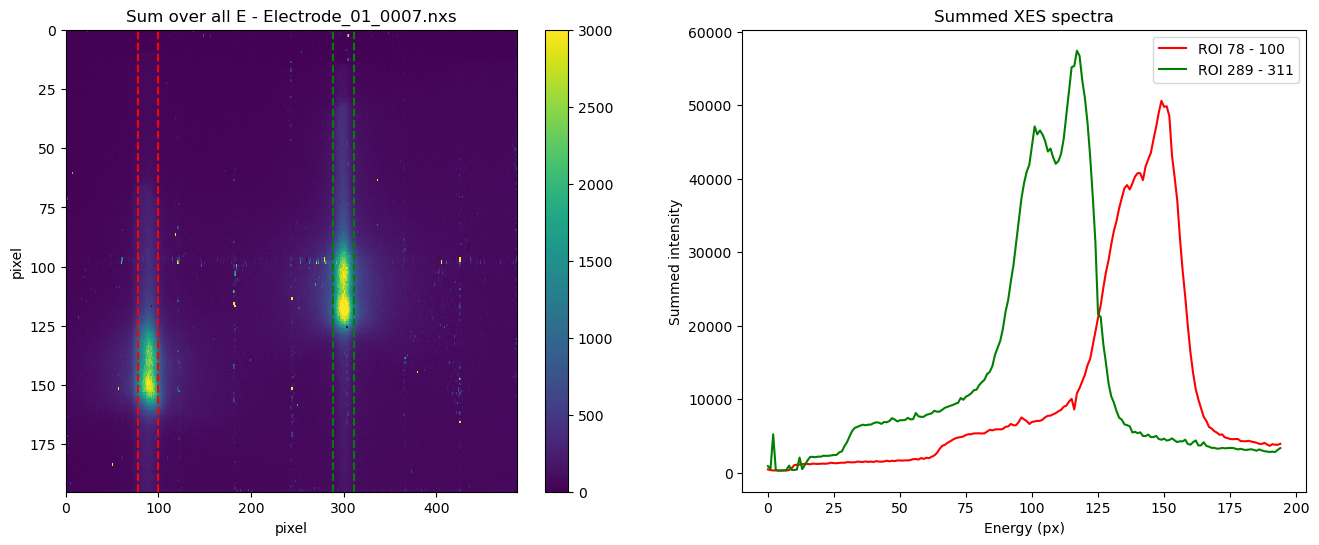

In [3]:
filename = 'Electrode_01_0007.nxs'
data_from_file = read_nxs_file(filename)
pilatus_image = data_from_file['images']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), squeeze=False)

ax: matplotlib.axes.Axes
ax = axs[0, 0]
ax.set_title('Sum over all E - ' + filename)

summed_pilatus = np.sum(pilatus_image, axis=0) #summ of all images on the detector, during the entire scan
im = ax.pcolormesh(summed_pilatus, shading='auto', vmax = 3000,  vmin=0)
ax.set_ylim(195, 0)
ax.set_xlabel('pixel')
ax.set_ylabel('pixel')
fig.colorbar(im, ax=ax)

rois = find_multiple_rois(summed_pilatus, threshold_factor=0.4, min_region_width=2)

colors = ['red', 'green', 'blue',]

for (left, right), color in zip(rois, colors):
    ax.axvline(left, color=color, linestyle='--')
    ax.axvline(right, color=color, linestyle='--')

pixel_calibration = np.array([2.02640772e-01, 2.44374424e+03])
pixel_calibration = np.array([1,0])  # slope, intercept: initial pixel calibration, need to be automatically determined
E2 = np.polyval(pixel_calibration, np.arange(0, 195))
ax = axs[0, 1]

for (left, right), color in zip(rois, colors):
        ax.plot(E2, np.sum(pilatus_image[:, :, left:right], axis=(0, 2)), color = color, label = 'ROI ' + str(left) + ' - ' + str(right) + '')
ax.set_title(f'Summed XES spectra')
ax.set_xlabel('Energy (px)')
ax.set_ylabel('Summed intensity')
ax.legend()

In [4]:
rois

[(np.int64(78), np.int64(100)), (np.int64(289), np.int64(311))]

# Pixel calibration of a spectrum from RIXS map

/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


Text(0, 0.5, 'Summed intensity')

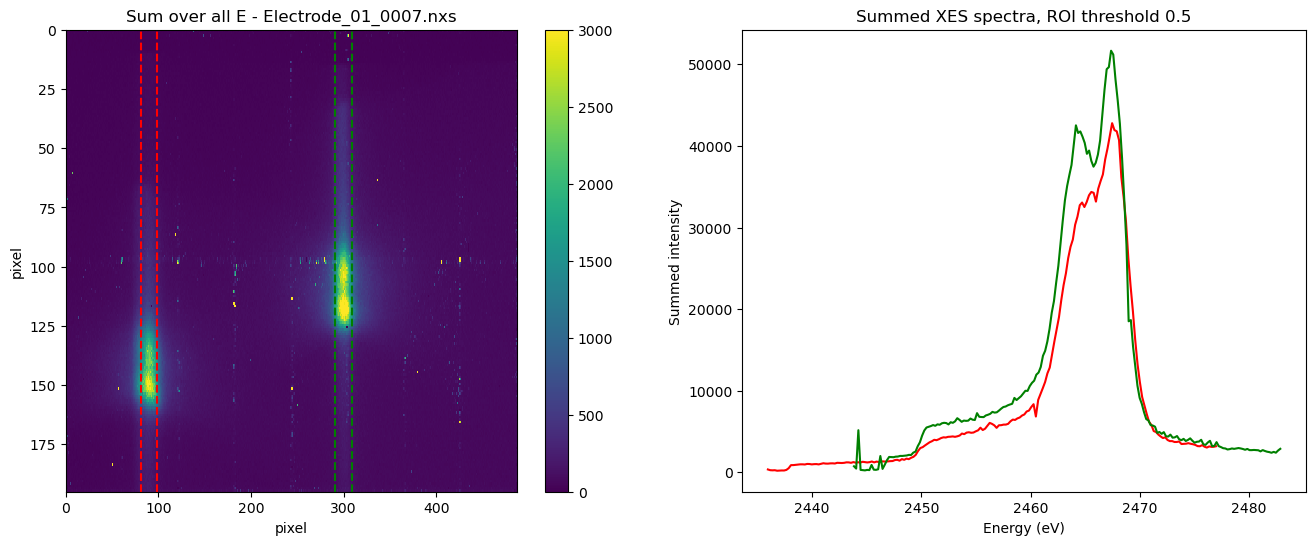

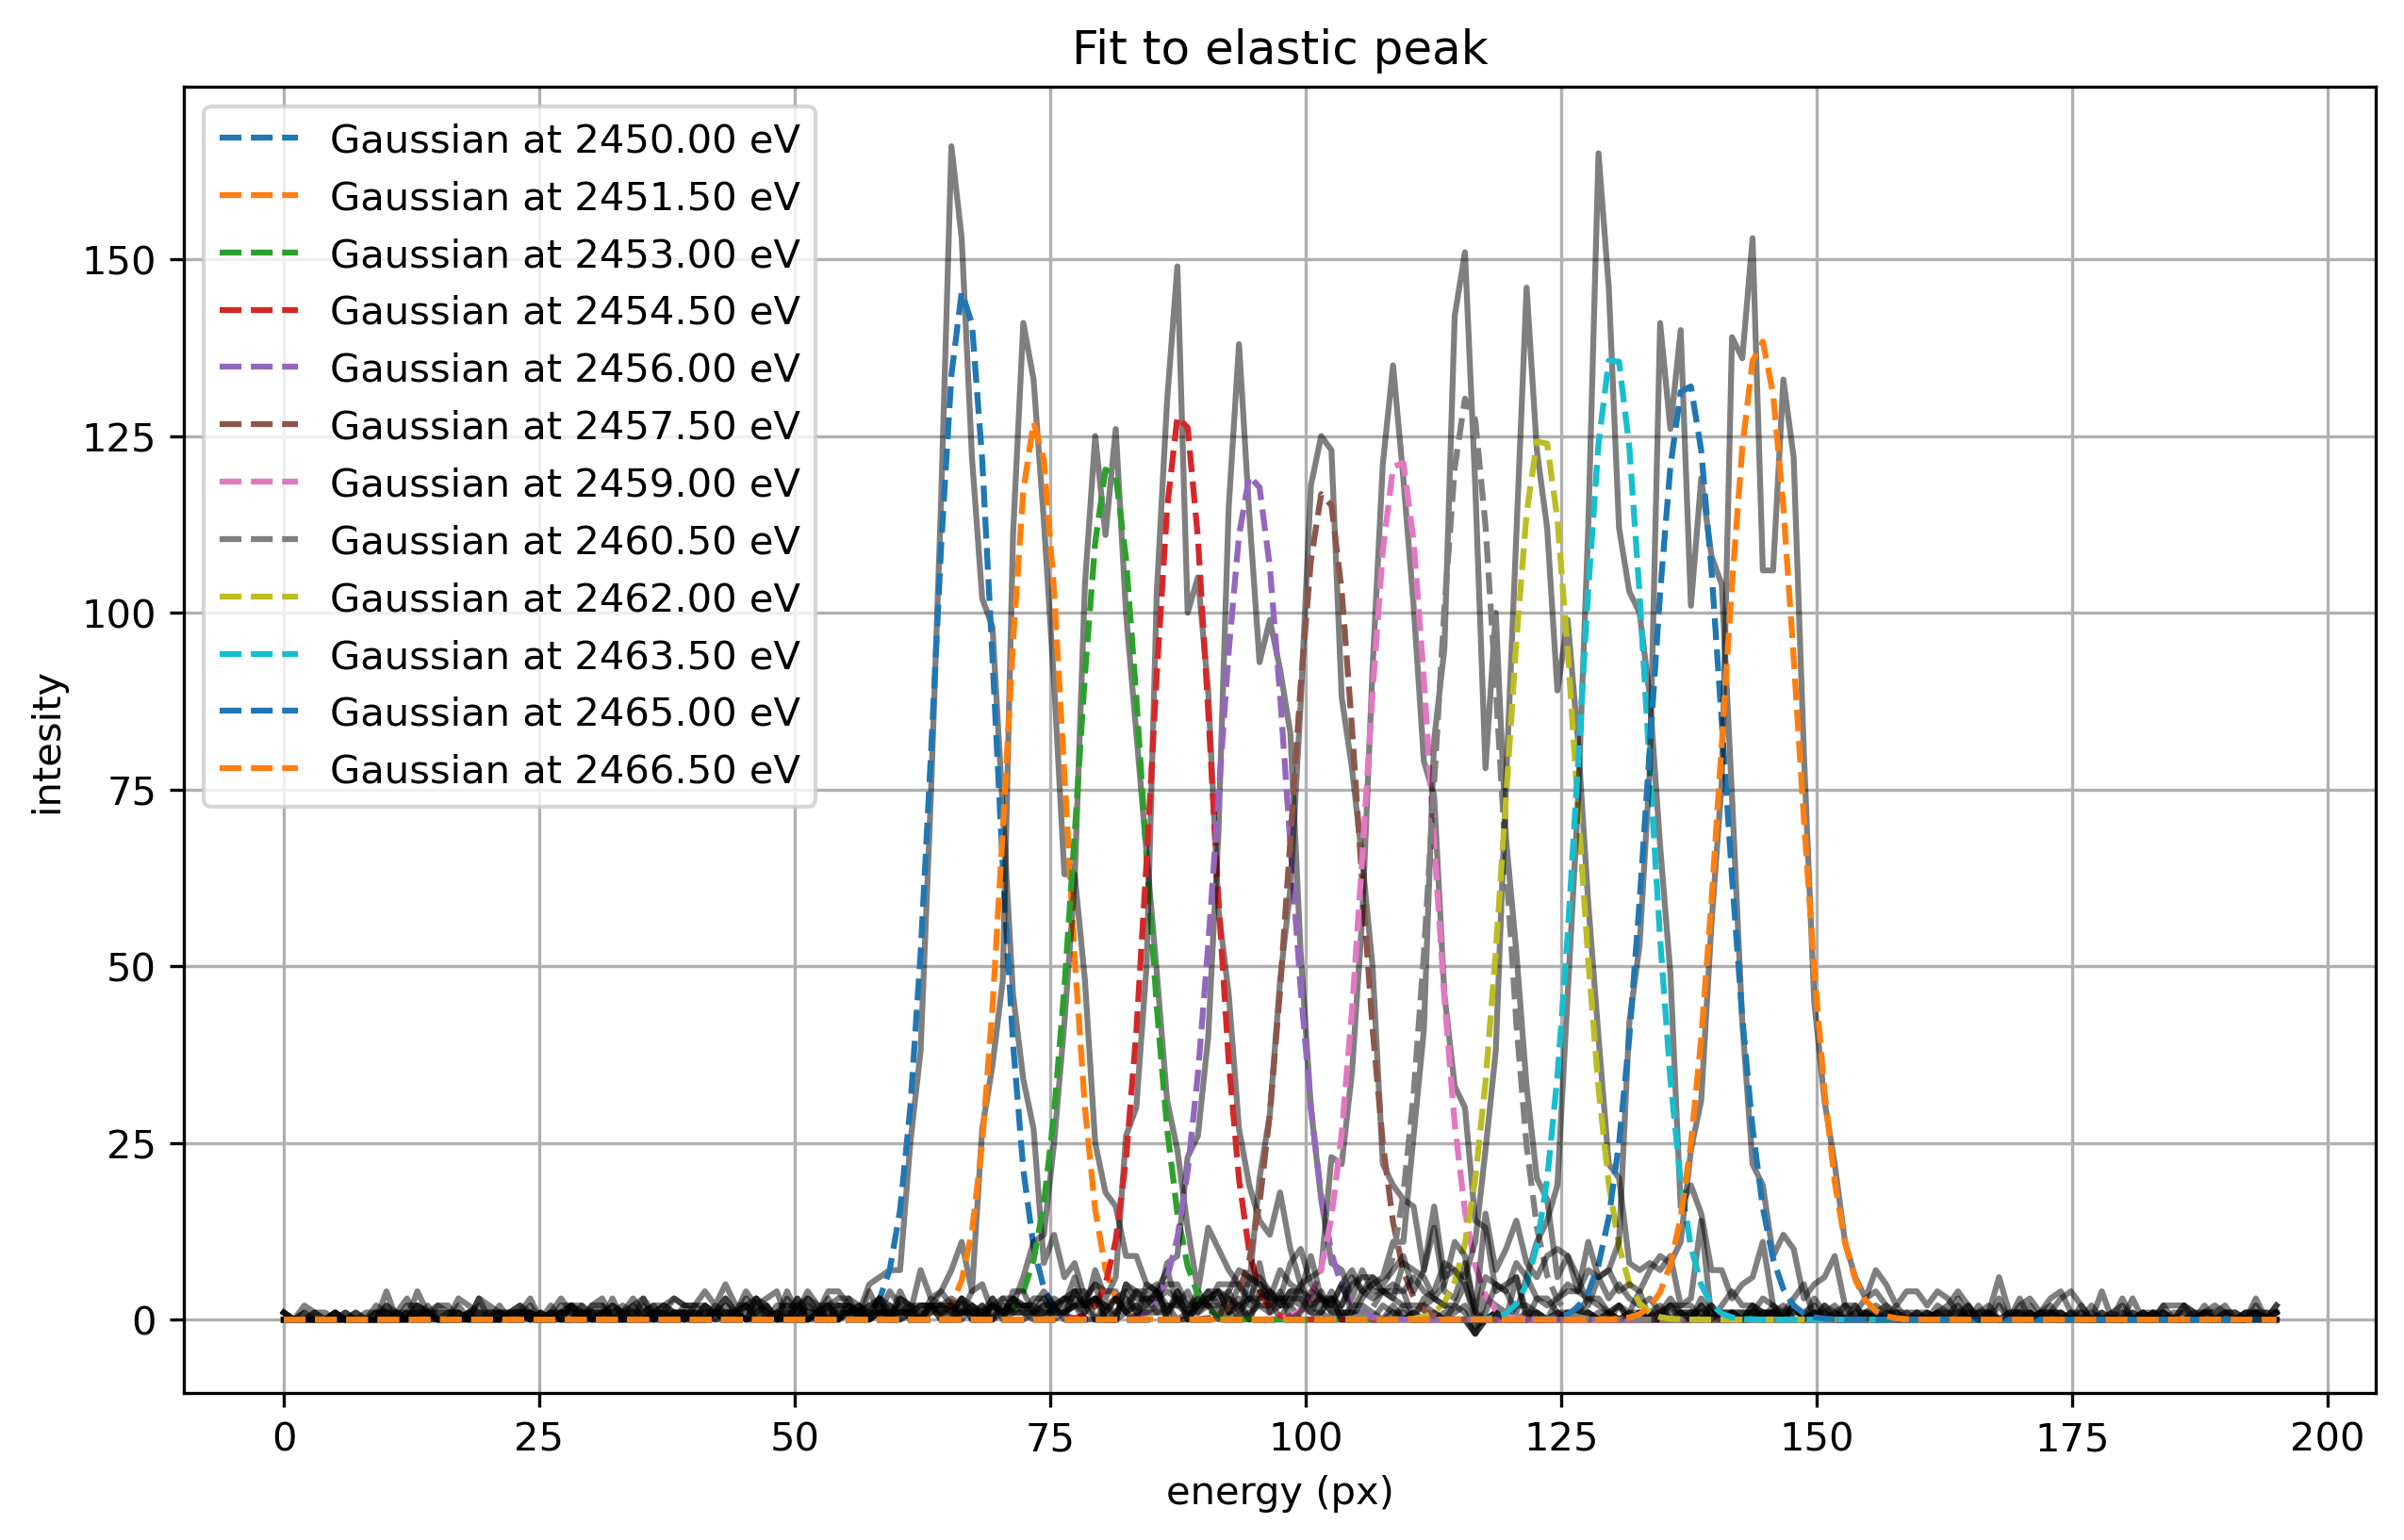

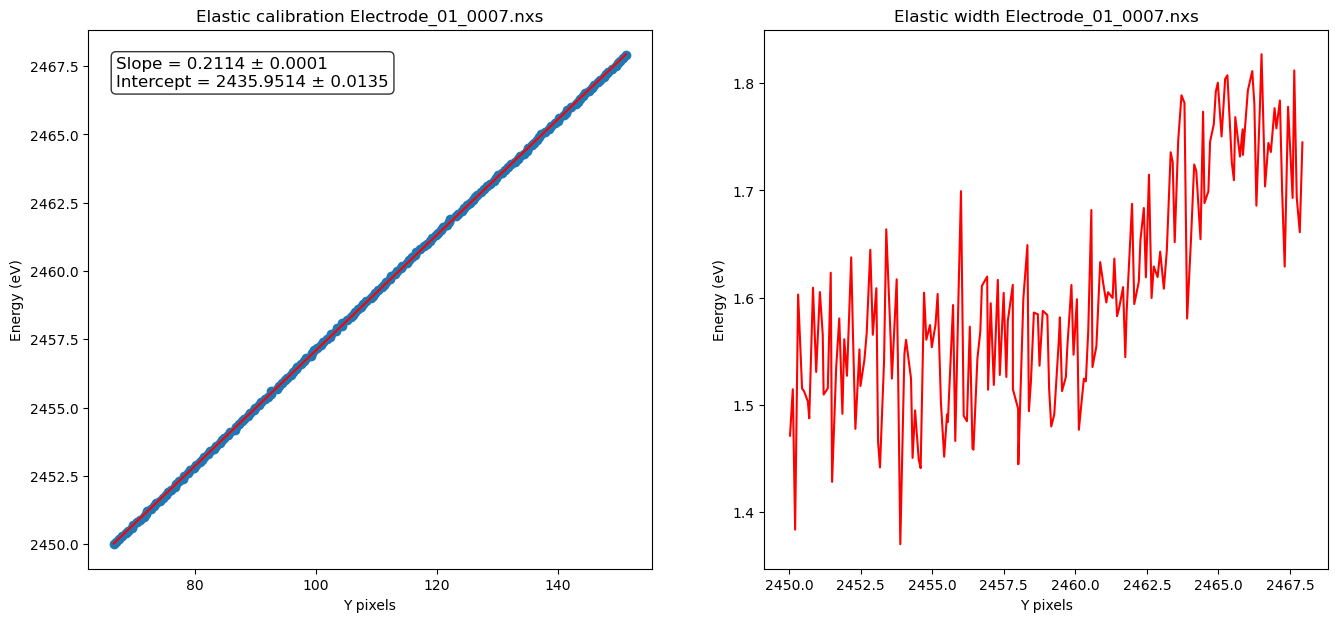

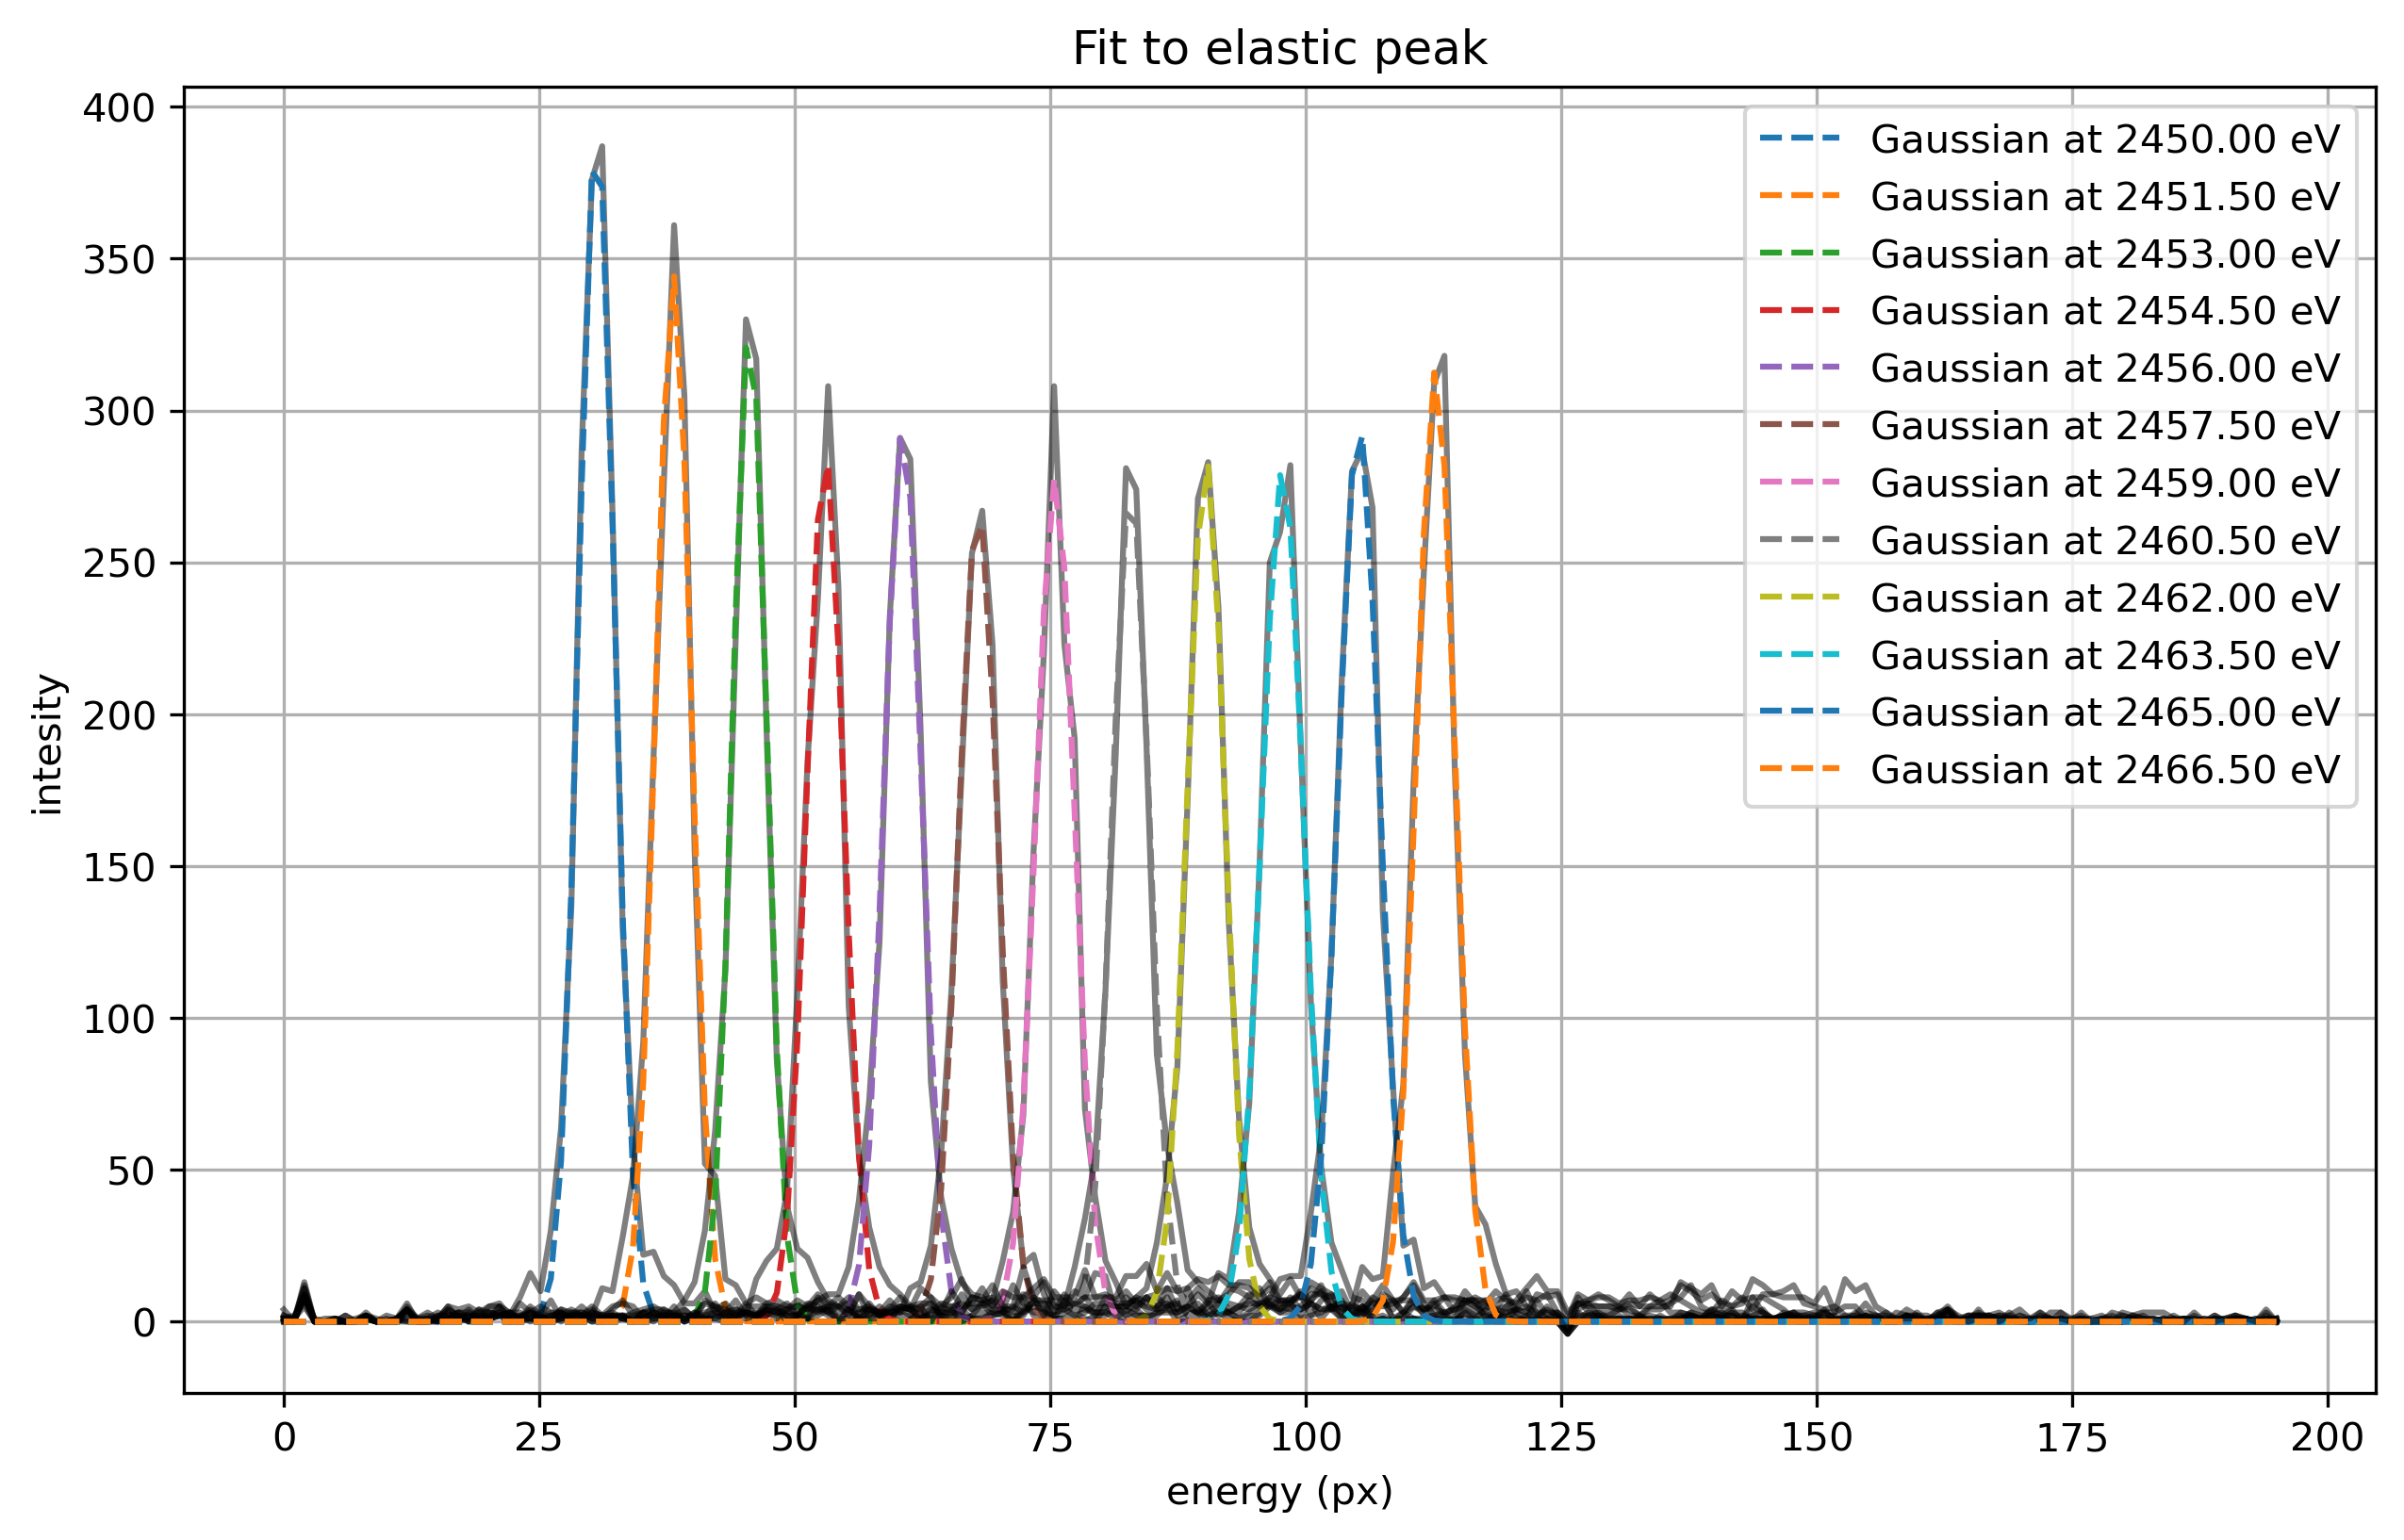

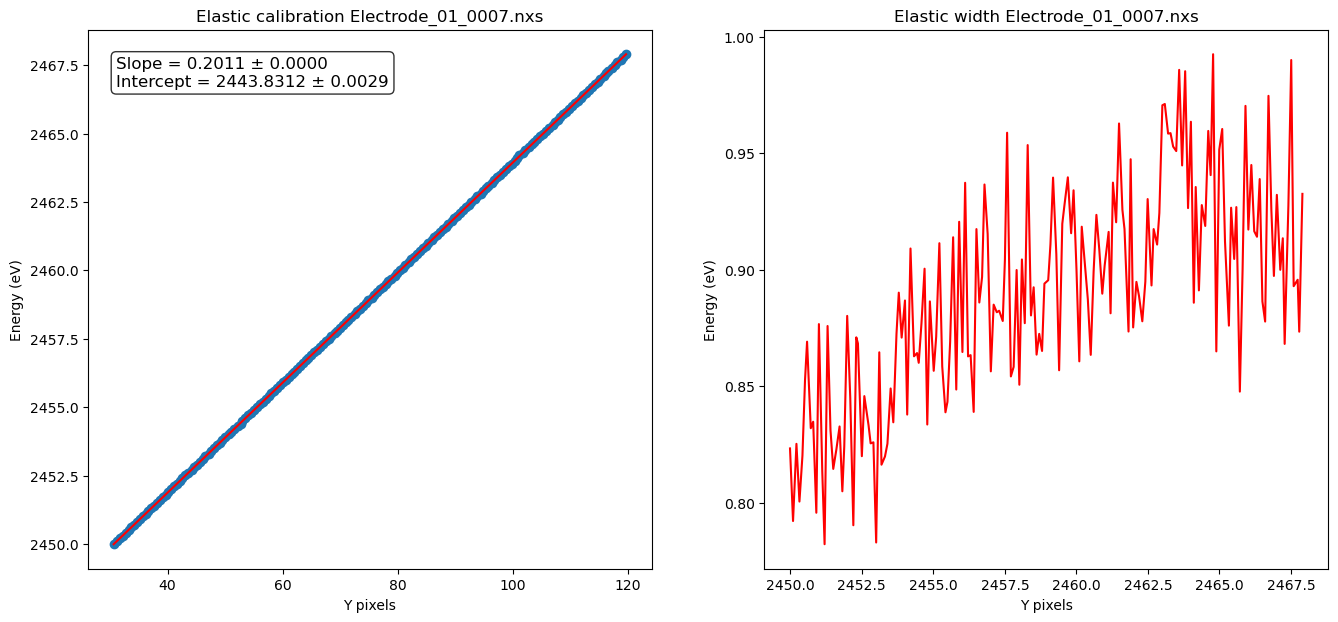

In [5]:
from galaxies_ava import energy_calibration


filename = 'Electrode_01_0007.nxs'
data_from_file = read_nxs_file(filename)
pilatus_image = data_from_file['images']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), squeeze=False)

summed_pilatus = np.sum(pilatus_image, axis=0)

ax: matplotlib.axes.Axes
ax = axs[0, 0]
ax.set_title('Sum over all E - ' + filename)
im = ax.pcolormesh(summed_pilatus, shading='auto',vmax = 3000, vmin=0)
ax.set_ylim(195, 0)
ax.set_xlabel('pixel')
ax.set_ylabel('pixel')
fig.colorbar(im, ax=ax)
thr = .5

rois = find_multiple_rois(summed_pilatus, threshold_factor=thr, min_region_width=2)

colors = ['red', 'green', 'blue',]

for (left, right), color in zip(rois, colors):
    ax.axvline(left, color=color, linestyle='--')
    ax.axvline(right, color=color, linestyle='--')

ax = axs[0, 1]
for (roi_left, roi_right), color in zip(rois, colors):
    pixel_calibration = (energy_calibration(filename,[roi_left, roi_right]))
    E2 = np.polyval(pixel_calibration, np.arange(0, 195))
    ax.plot(E2, np.sum(pilatus_image[:, :, roi_left:roi_right], axis=(0, 2)), color = color)


ax.set_title(f'Summed XES spectra, ROI threshold {thr}')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Summed intensity')


In [6]:
rois

[(np.int64(81), np.int64(98)), (np.int64(291), np.int64(309))]

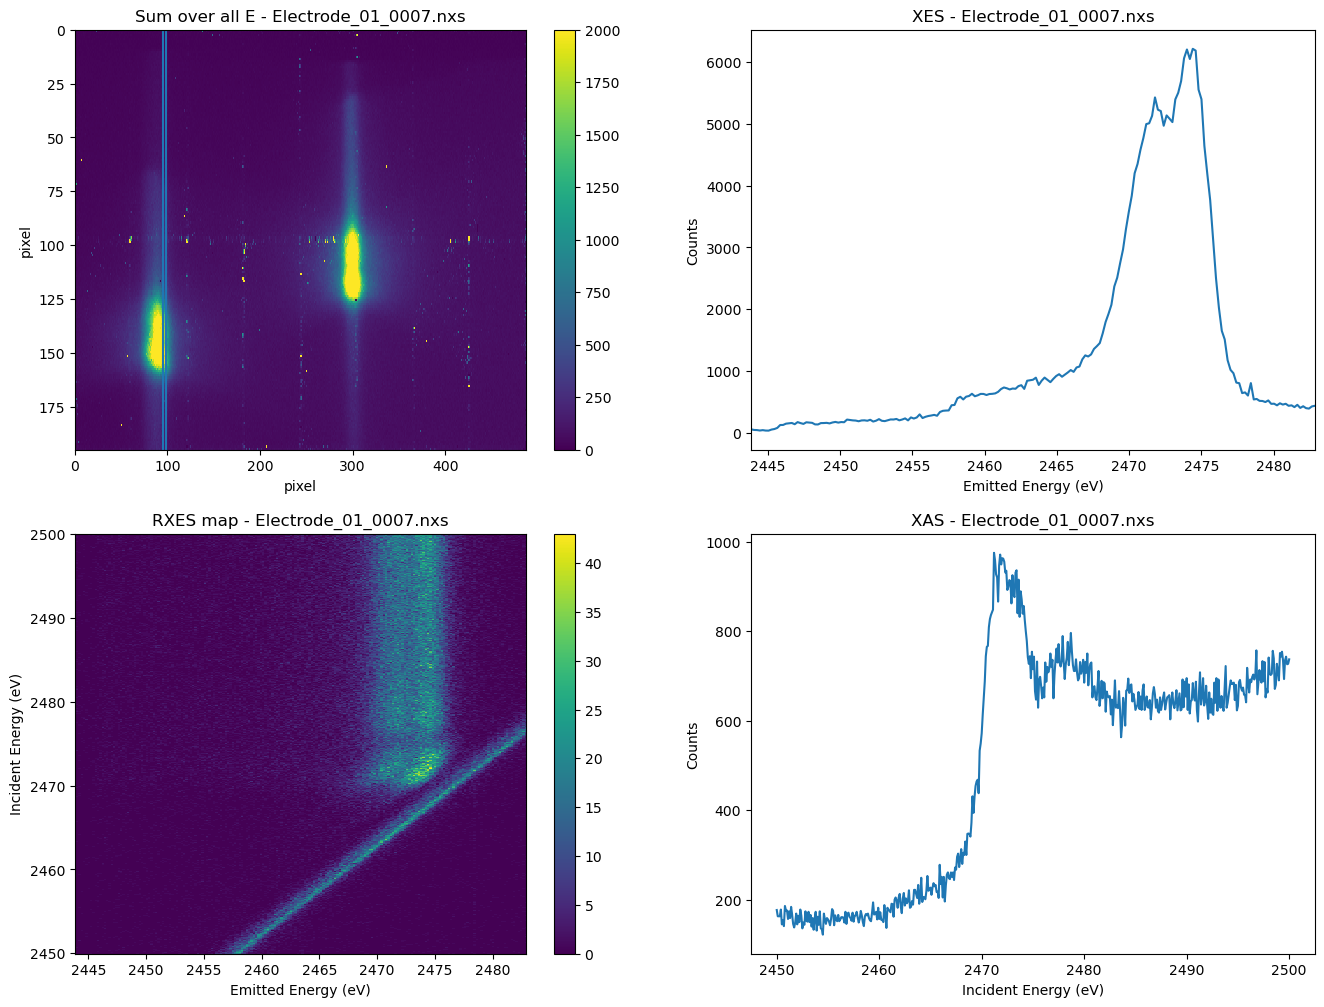

In [7]:
plot_2Dmap(filename, pixel_calibration, [95, 98], vmax_sum=2000)

# Investigate elastic edge

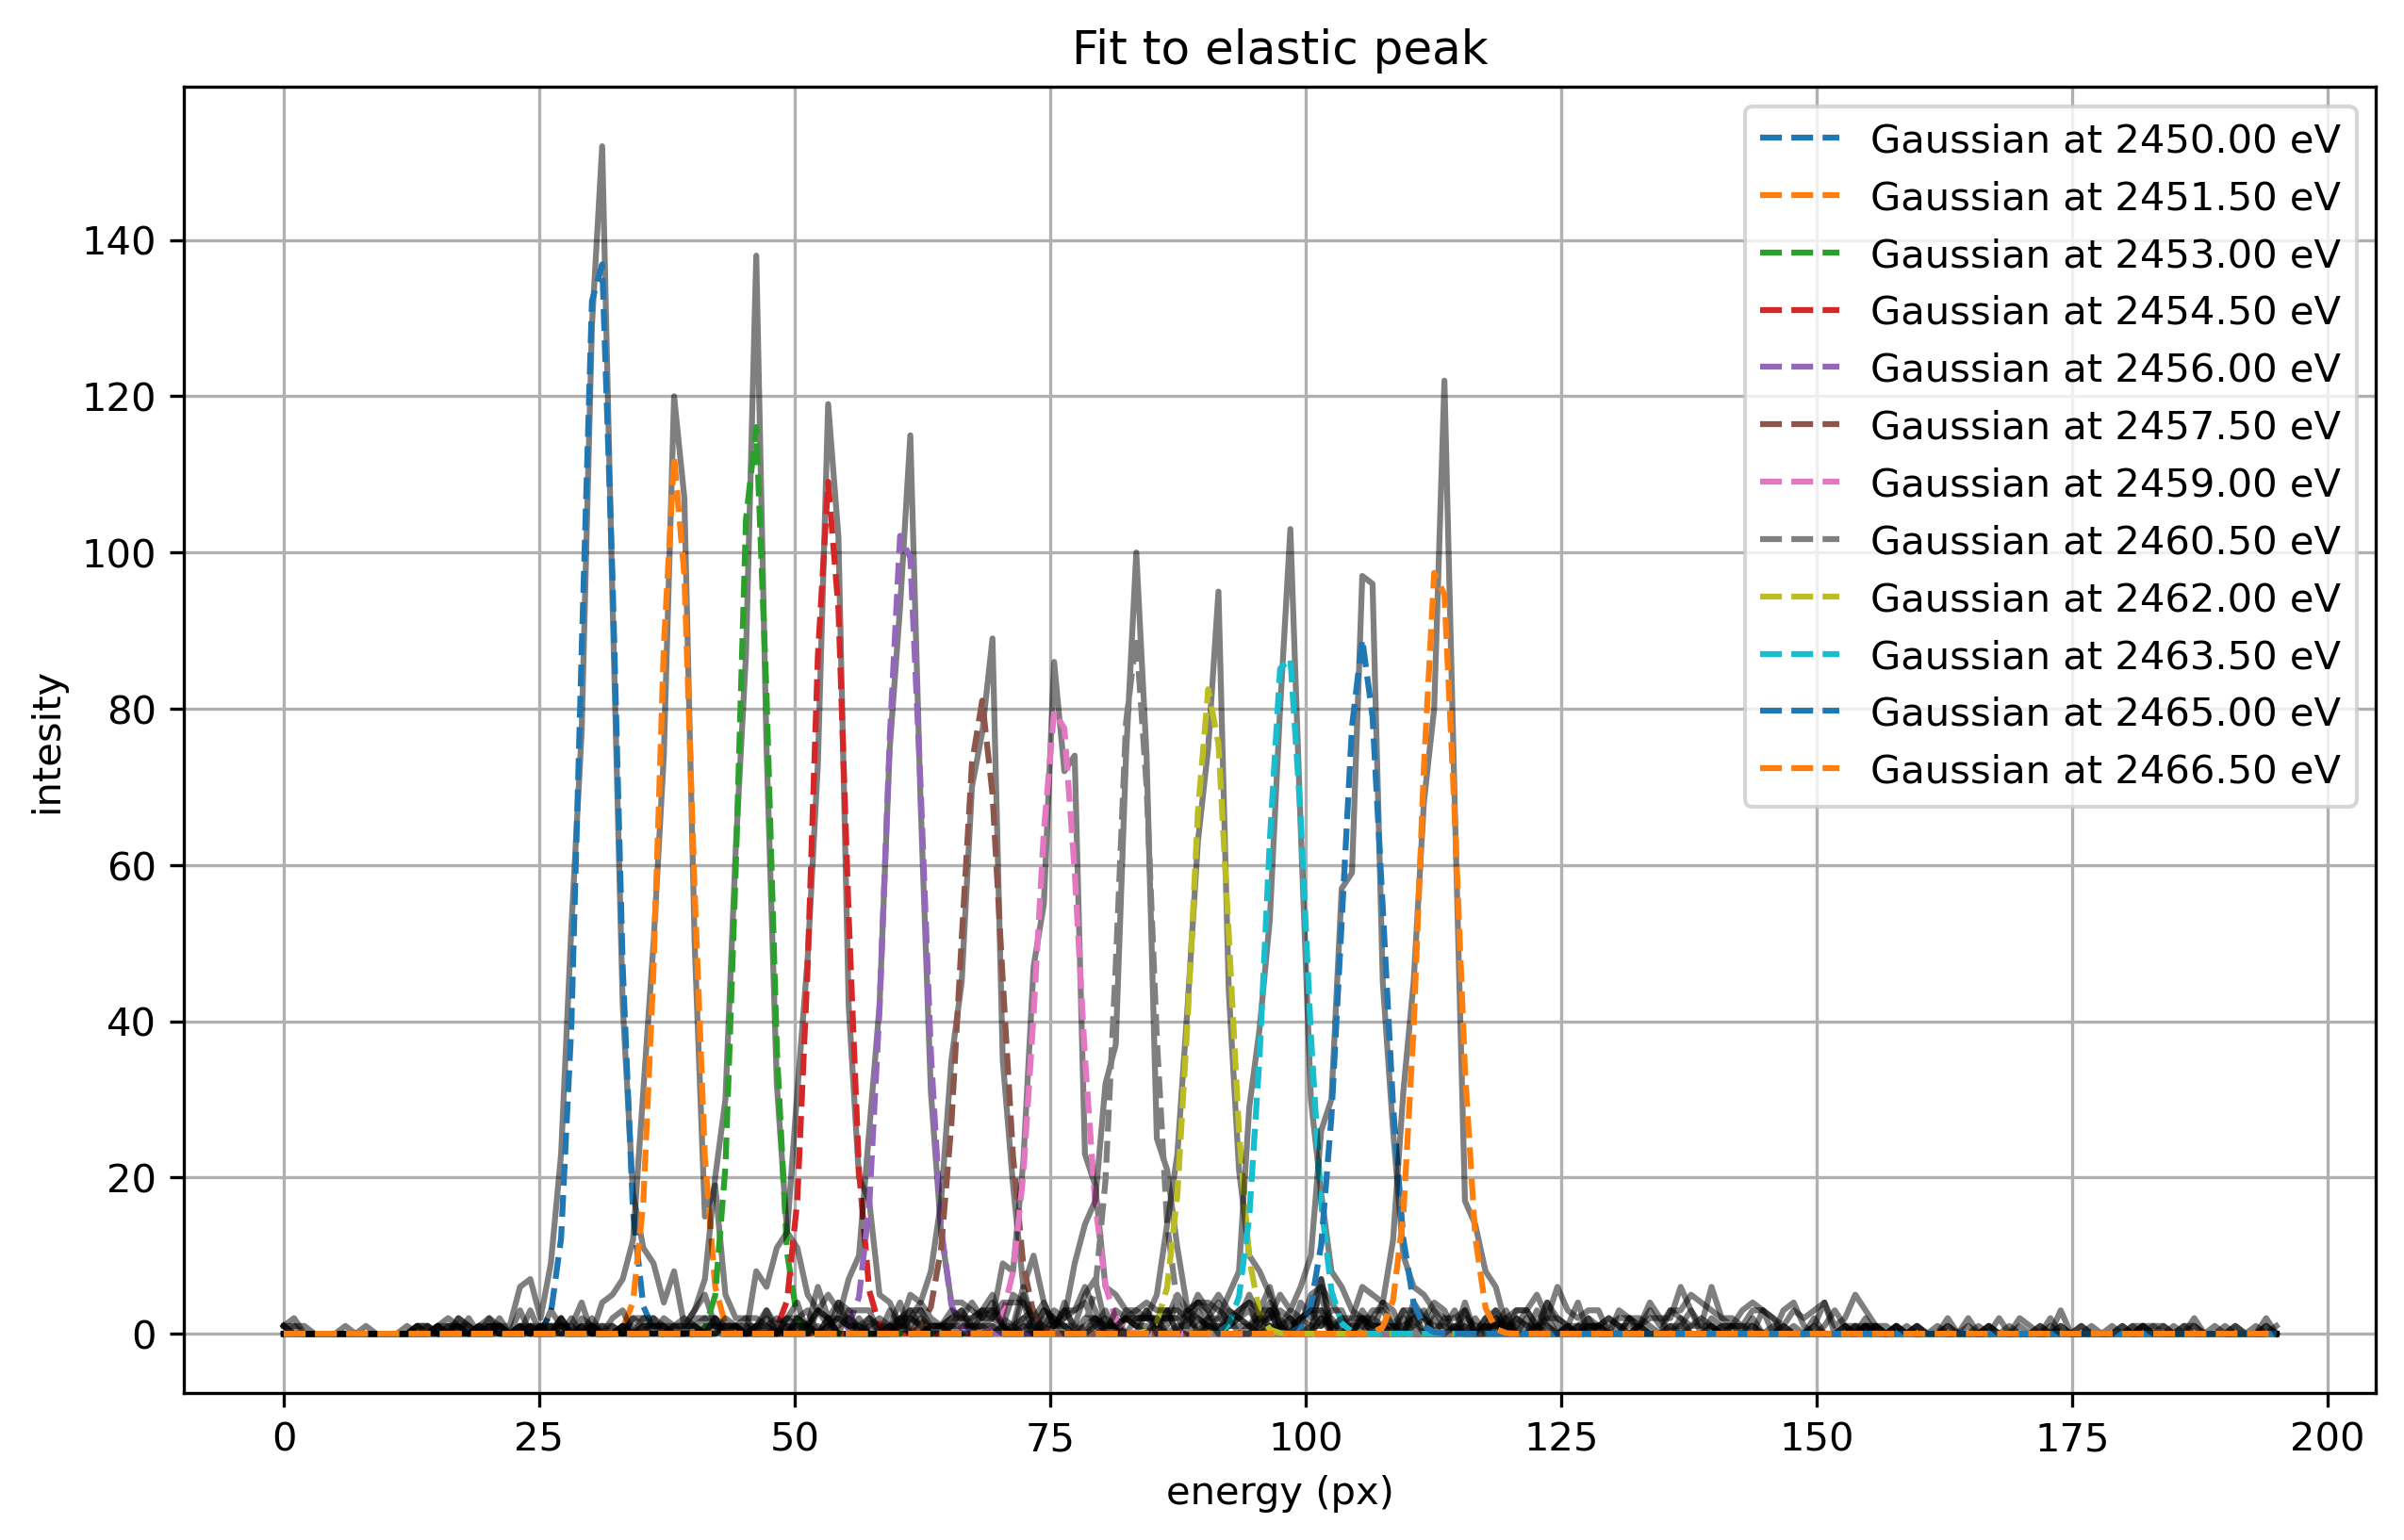

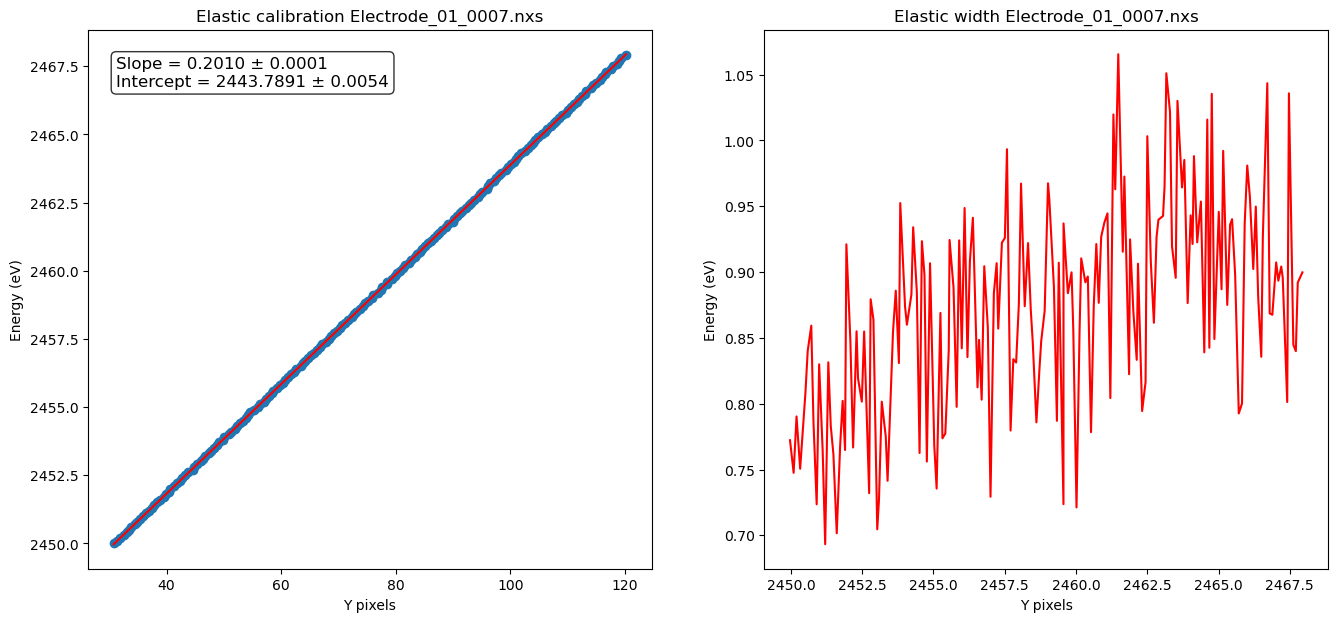

In [8]:
filename = 'Electrode_01_0007.nxs'
data_from_file = read_nxs_file(filename)
pilatus_image = data_from_file['images']
summed_pilatus = np.sum(pilatus_image, axis=0)
energies = data_from_file['energies']

thr = .4
rois = find_multiple_rois(summed_pilatus, threshold_factor=thr, min_region_width=2)

ROI1 = rois[0]
ROI1 = [294,299]
pixel_calibration = (energy_calibration(filename,[ROI1[0], ROI1[1]], plot=True))
#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16, 6), squeeze=False)


ax = axs[0, 0]
##ax.plot(E2, np.sum(pilatus_image[0, :, ROI1[0]:ROI1[1]], axis= 1), color = color)






Text(0.5, 1.02, 'Elastic Peak Analysis for ROI: [294][299]')

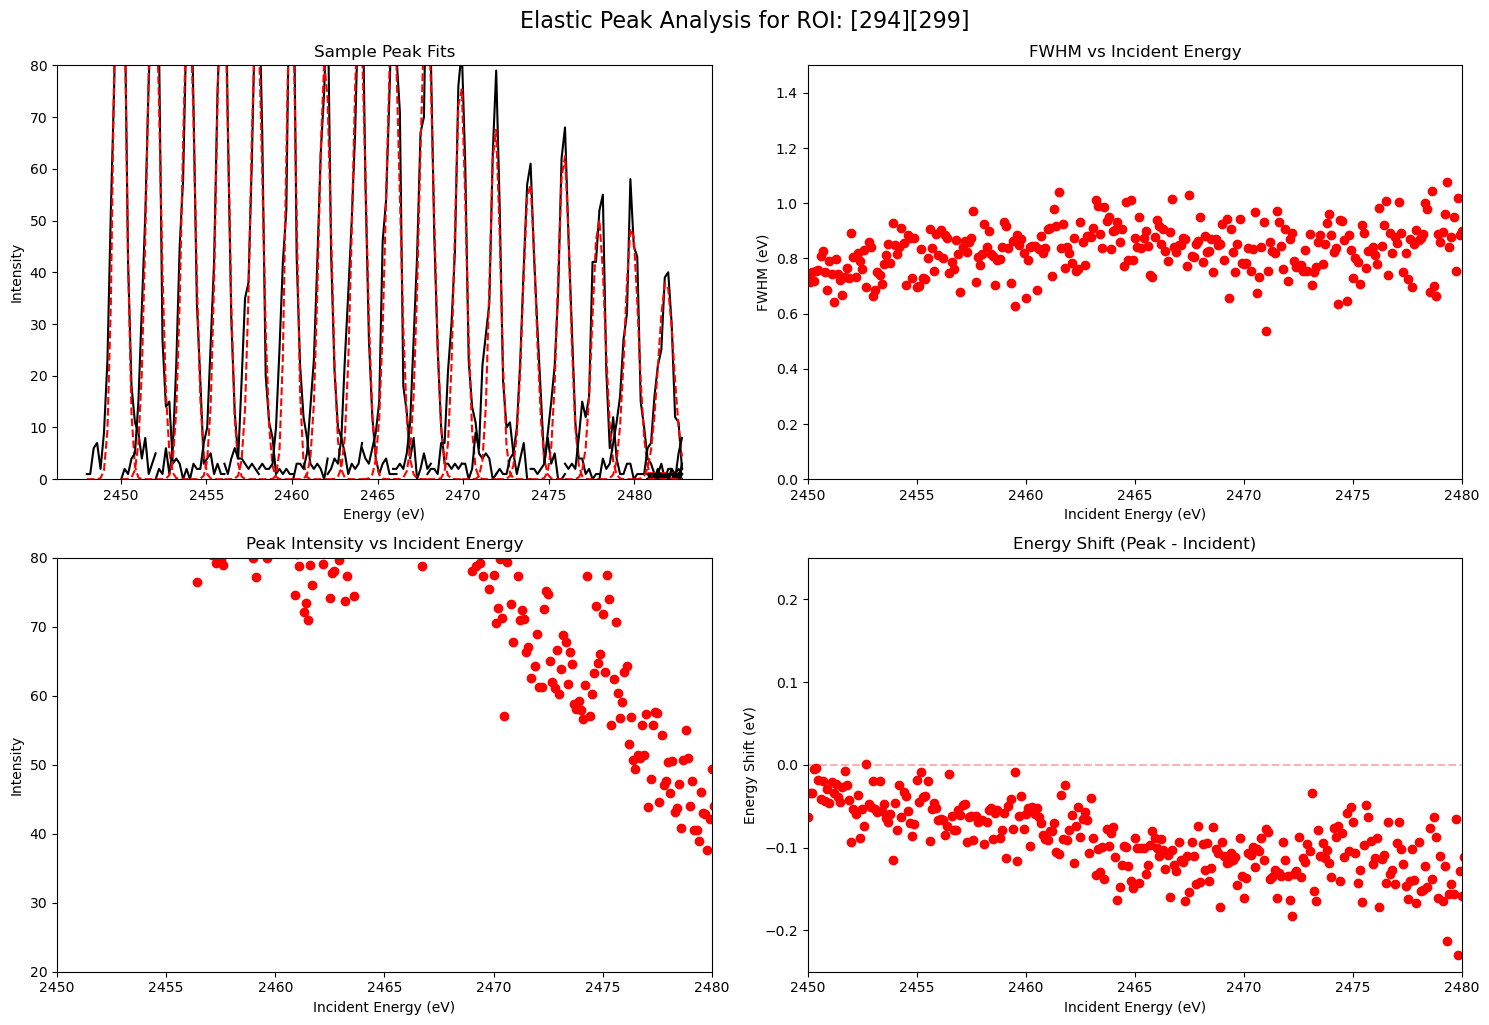

In [9]:
from lmfit.models import GaussianModel, PolynomialModel, LinearModel, LorentzianModel, VoigtModel
elastics = []
x_maxs = []
fwhms = []
intensities = []
areas = []
peak_positions = []


energy = np.polyval(pixel_calibration, np.arange(0, 195))
ax = axs[0, 0]

window_size = 10
fig, axs = plt.subplots(2, 2, figsize=(15, 10))




for N, (e, data) in enumerate(zip(energies, pilatus_image)):
    target_energy = e
    peak_idx = np.argmin(np.abs(energy - target_energy))
    start_idx = max(0, peak_idx - window_size)
    end_idx = min(len(energy), peak_idx + window_size + 1)

    elastic = np.sum(data[:,ROI1[0]:ROI1[1]], axis=1)[start_idx:end_idx]
    elastics.append(elastic)

    x_data = energy[start_idx:end_idx]
    y_data = elastic

    background_order = 1
    back_model = PolynomialModel(degree=background_order, prefix='bkg_')
    gauss_model = GaussianModel(prefix='g_')
    model = back_model + gauss_model
    params = model.make_params()
    for i in range(background_order + 1):
        params[f'bkg_c{i}'].set(value=1)

    params['g_amplitude'].set(value=np.max(y_data), min=0)
    params['g_center'].set(value=e)
    params['g_sigma'].set(value = 0.5)


    result = model.fit(y_data, params, x = x_data)

    fwhms.append(2.355 * result.params['g_sigma'].value)
    intensities.append(result.params['g_height'].value)
    areas.append(result.params['g_amplitude'].value)
    peak_positions.append(result.params['g_center'].value)


    ax = axs[0, 0]
    if N%20 == 0:
        ax.plot(energy[start_idx:end_idx], elastic, label=f'energy: {target_energy:.2f} eV', color = 'black')
        ax.plot(x_data, result.eval_components(x=x_data)['g_'], '--', color = 'red')

ax = axs[0, 0]
ax.set_title('Sample Peak Fits')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Intensity')
ax.set_ylim(0,80)


ax = axs[0, 1]
ax.plot(energies, fwhms, 'o', color = 'red')
ax.set_title('FWHM vs Incident Energy')
ax.set_xlabel('Incident Energy (eV)')
ax.set_ylabel('FWHM (eV)')
ax.set_ylim(0,1.5)
ax.set_xlim(2450,2480)

ax = axs[1, 0]
ax.plot(energies, intensities, 'o',color = 'red')
ax.set_title('Peak Intensity vs Incident Energy')
ax.set_xlabel('Incident Energy (eV)')
ax.set_ylabel('Intensity')
ax.set_ylim(20,80)
ax.set_xlim(2450,2480)

ax = axs[1, 1]


energy_shifts = np.array(peak_positions) - np.array(energies)

ax.plot(energies, energy_shifts, 'o',color = 'red')
ax.set_title('Energy Shift (Peak - Incident)')
ax.set_xlabel('Incident Energy (eV)')
ax.set_ylabel('Energy Shift (eV)')
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)  # Add zero-line reference


ax.set_xlim(2450,2480)
ax.set_ylim(-0.25,0.25)
plt.tight_layout()


results_df = pd.DataFrame({
    'Incident_Energy': energies,
    'FWHM': fwhms,
    'Peak_Height': intensities,
    'Area': areas,
})



#p

fig.suptitle(f'Elastic Peak Analysis for ROI: [{ROI1[0]}][{ROI1[1]}]', fontsize=16, y=1.02)

#plot energy calibrated elastic peaks:


In [88]:
def calibrate_line(*, filename: str, roi, line_ends: tuple, vmax=None, plot=True):

    data = read_nxs_file(filename)
    pilatus_image = data['images']
    energy = data['energies']
    logger.debug("Read %i images with %i energies", len(pilatus_image), len(energy))
    logger.debug("Image tensor dimensions: {}".format(pilatus_image.shape))


    pilatus_sum = np.sum(pilatus_image[:, :, roi[0]:roi[1]], axis=2)


    approx_line_ene2pix = np.polyfit(line_ends[0], line_ends[1], 1)
    pixel_axis =  np.arange(0, 195)

    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(15, 15))
        ax = axs[0, 0]
        ax.set_title(f"Sum ROI {roi[0]}-{roi[1]} of {filename}")
        g1 = ax.pcolormesh(np.arange(0, 195), energy, pilatus_sum , vmax=vmax)
        plt.colorbar(g1, ax=ax)
        ax.set_xlabel("pixel")
        ax.set_ylabel("Incident Energy [eV]")
        ax.set_xlim(0,195)
        ax.plot(np.polyval(approx_line_ene2pix,energy), energy,color = 'red')






    fit_results = []
    for j, (e, data) in enumerate(zip(energy, pilatus_sum)):

        x_max = int(np.polyval(approx_line_ene2pix,e)) #at which pixel are we looking for elastic peak a
        if x_max > data.shape[0]-15: #stop when we run out of pixels (elastic runs out)
                continue
        # presumed peakmaks 5 px left and right from the
        #mask = [x_max-5:x_max+5]


        rng = 20
        x = np.linspace(0,len(pixel_axis),len(pixel_axis))[x_max-rng+5:x_max+rng]
        y = data[x_max-rng+5:x_max+rng]

        background_order = 1
        back_model = PolynomialModel(degree=background_order, prefix='bkg_')
        gauss_model = GaussianModel(prefix='g_')
        model = back_model + gauss_model
        params = model.make_params()

        for i in range(background_order + 1):
            params[f'bkg_c{i}'].set(value=1)

        params['g_amplitude'].set(value=np.max(y), min=0)
        params['g_center'].set(value=x[np.argmax(y)])
        params['g_sigma'].set(value = 0.5)

        result = model.fit(y, params, x=x)

        fit_results.append({
        'energy': e,
        'g_amplitude': result.params['g_amplitude'].value,
        'g_center': result.params['g_center'].value,
        'g_fwhm': 2.3548 * result.params['g_sigma'].value,
        'g_intensities': result.params['g_height'].value,
#        'bkg_c0': result.params['bkg_c0'].value,
#        'bkg_c1': result.params['bkg_c1'].value,
    })

        if plot and j%50 == 0:
            ax = axs[0, 1]
            ax.plot(x, y, color='black')
            # ax.plot(x_fit, result.best_fit, color = 'red', label = 'fit')
            #ax.plot(x, result.eval_components(x=x)['bkg_'], '--', label='Background')

            ax.plot(x, result.eval_components(x=x)['g_'], '--', label=f'Gaussian at {e:.2f} eV')
            ax.axvline(x_max,color='gray', alpha = 0.5, linestyle='--'
)
            ax.set_title(f'Fit to elastic peak')
            ax.set_xlabel('energy (px)')
            ax.set_ylabel(f'intesity')
            ax.grid(visible=True, alpha = 0.3)
            ax.legend()



    fit_data = pd.DataFrame(fit_results)
    #print(fit_data)

    lin_model = LinearModel(prefix='lin_')
    params = lin_model.make_params()
    result = lin_model.fit(fit_data['energy'], params, x=fit_data['g_center'])


    slope = result.params['lin_slope'].value
    slope_err = result.params['lin_slope'].stderr
    intercept = result.params['lin_intercept'].value
    intercept_err = result.params['lin_intercept'].stderr


    fit_text = (f"Slope = {slope:.4f} ± {slope_err:.4f}\n"
                f"Intercept = {intercept:.4f} ± {intercept_err:.4f}")

    line = np.array([result.params['lin_slope'].value, result.params['lin_intercept'].value])
    fwhm_e =  fit_data['g_fwhm']*result.params['lin_slope'].value
    mean = np.mean(fwhm_e)
    fit_data['e_fwhm'] = fwhm_e


    if plot:


        ax = axs[1, 0]
        ax.set_title('Enegy calibration' + filename)
        ax.scatter(fit_data['g_center'], fit_data['energy'], color = 'black',s = 10)
        ax.plot(fit_data['g_center'], result.best_fit, color = 'red', label = 'fit')
        ax.set_title(f'Elastic calibration {filename}')
        ax.set_xlabel('Y pixels')
        ax.grid(visible=True, alpha = 0.3)
        ax.set_ylabel(f'Energy (eV)')
        ax.text(0.05, 0.95, fit_text, transform=ax.transAxes,
                 fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


        ax = axs[1, 1]
        ax.set_title('Gauss FWHM' + filename)
        ax.plot(calibrate_energy_ax(fit_data['g_center'],line), fit_data['g_fwhm']*result.params['lin_slope'].value, color = 'black', label = 'fit')





        ax.set_title(f'Elastic peak width')
        ax.grid(visible=True, alpha = 0.3)
        ax.axhline(y=mean, color='r', linestyle='--', alpha=0.7)
        ax.text(0.05, 0.95, f"Mean FWHM = {mean:.4f}", transform=ax.transAxes,
                 fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_xlabel('Incident Energy (eV)')
        ax.set_ylabel(f'FWHM (eV)')


        ax = axs[2, 0]
        ax.plot(fit_data['energy'], fit_data['g_intensities'],color = 'black')
        ax.set_title('Elastic peak Intensity')
        ax.set_xlabel('Incident Energy (eV)')
        ax.set_ylabel('Intensity')
        ax.grid(visible=True, alpha = 0.3)

        ax = axs[2, 1]


        energy_shifts = np.array(np.polyval(line,fit_data['g_center'])-fit_data['energy'])

        ax.plot(fit_data['energy'], energy_shifts,color = 'black')
        ax.set_title('Energy Shift (Calibrated-True)')
        ax.set_xlabel('Incident Energy (eV)')
        ax.set_ylabel('Energy Shift (eV)')
        ax.grid(visible=True, alpha = 0.3)
        #ax.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        ax.axhline(y=np.mean(energy_shifts), color='r', linestyle='--', alpha=0.7)# Add zero-line reference

        plt.tight_layout()
    #df = pd.DataFrame.from_dict(fit_data)

    return fit_data
    #return np.array([result.params['lin_slope'].value, result.params['lin_intercept'].value])

def calibrate_energy_ax(data, line):
    data = np.array(data)
    k = line[0]
    n = line[1]
    return data*k + n

/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


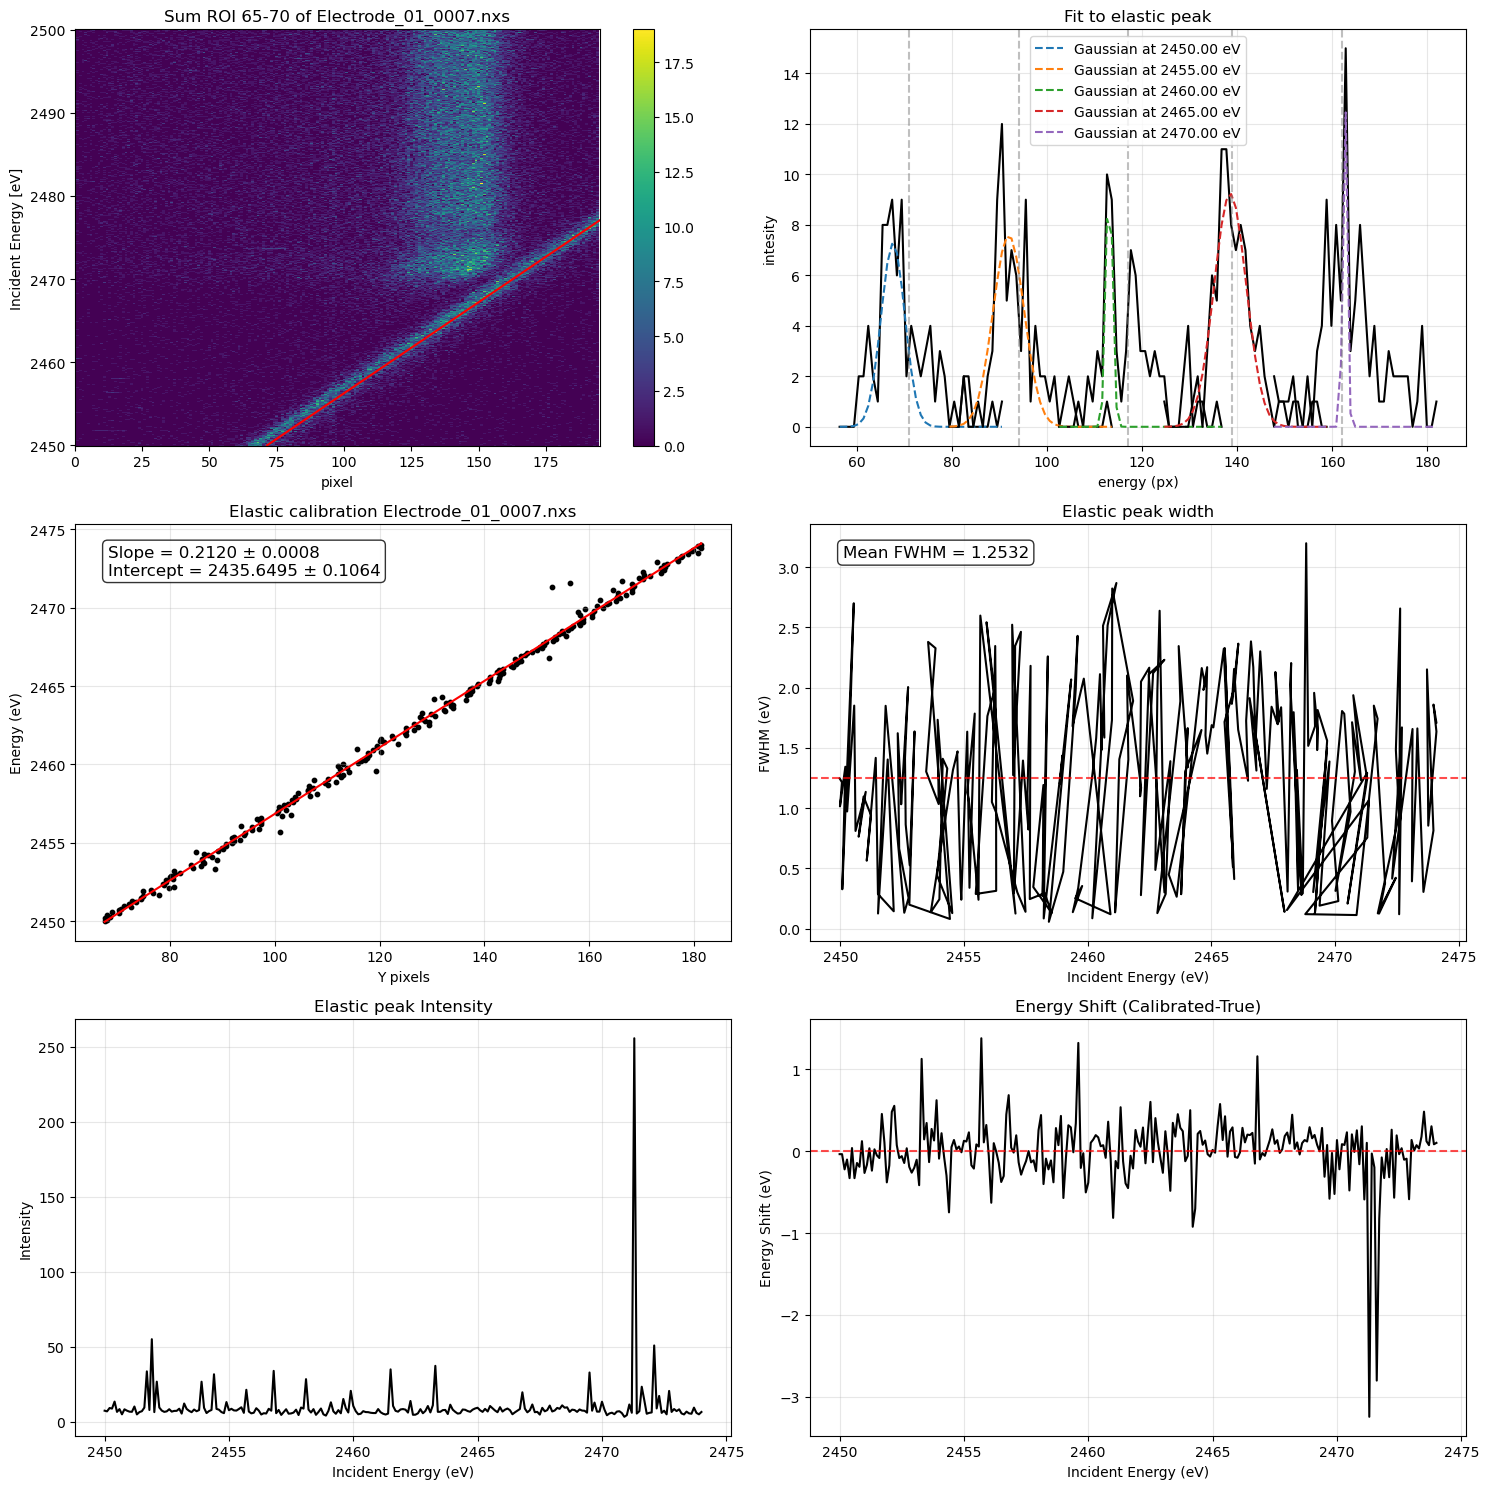

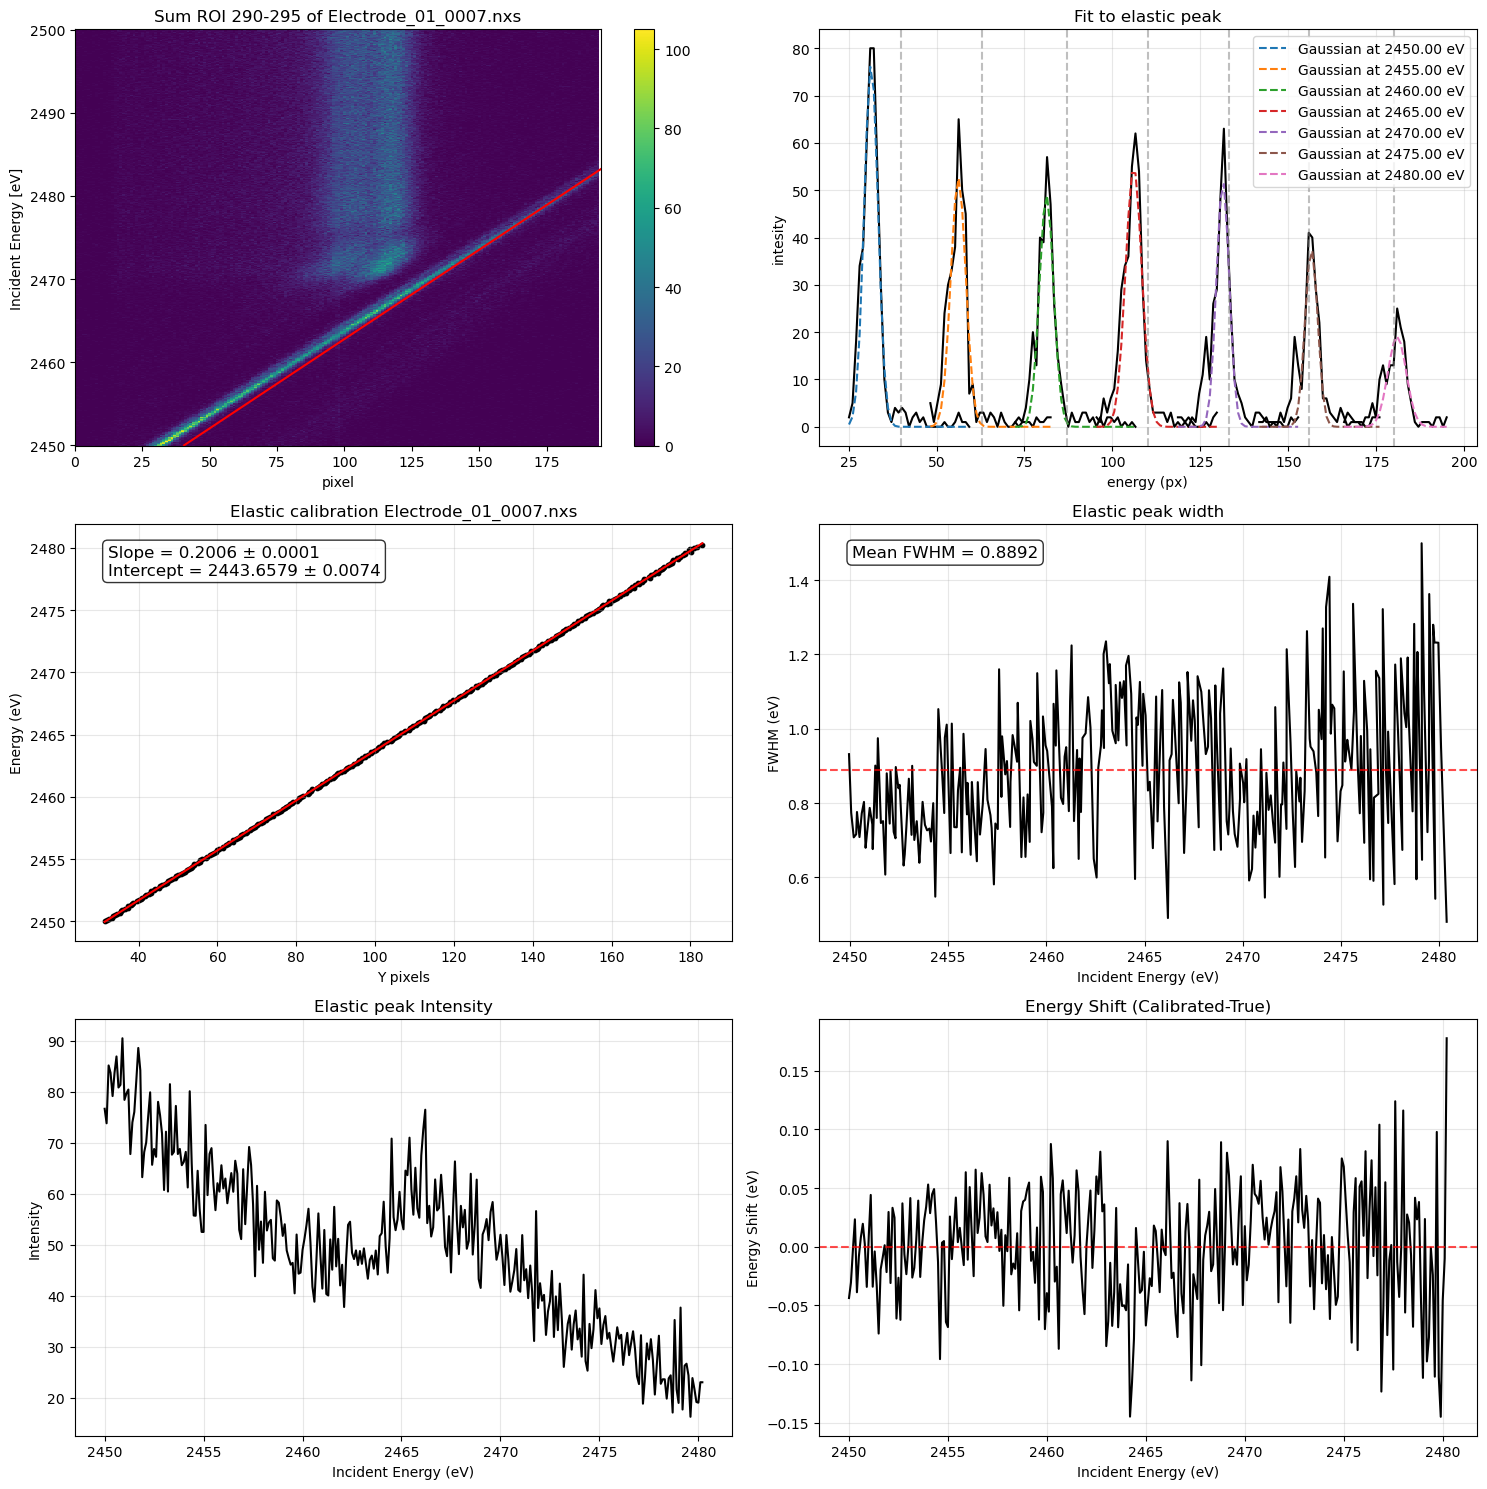

In [104]:
def foo():
    # logger.setLevel(logging.DEBUG)
    input_data = ({
        'filename': 'Electrode_01_0007.nxs',
        'roi': [65,70],
        'line_ends': ((2460, 2476), (117, 190))
        },
        {
        'filename': 'Electrode_01_0007.nxs',
        'roi': [290,295],
        'line_ends': ((2460, 2480), (87, 180))
        },
    )
    for idata in input_data:
        results = calibrate_line(**idata, plot=True)


foo()

# Investigte ROI width

/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/ava/anaconda3/envs/mosarix/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/home/ava/anaconda3/

offsets    e_fwhm
0        1  1.135832
1        6  0.975822
2       11  0.891569
3       16  0.785643
4       21  0.823602
5       26  1.065441

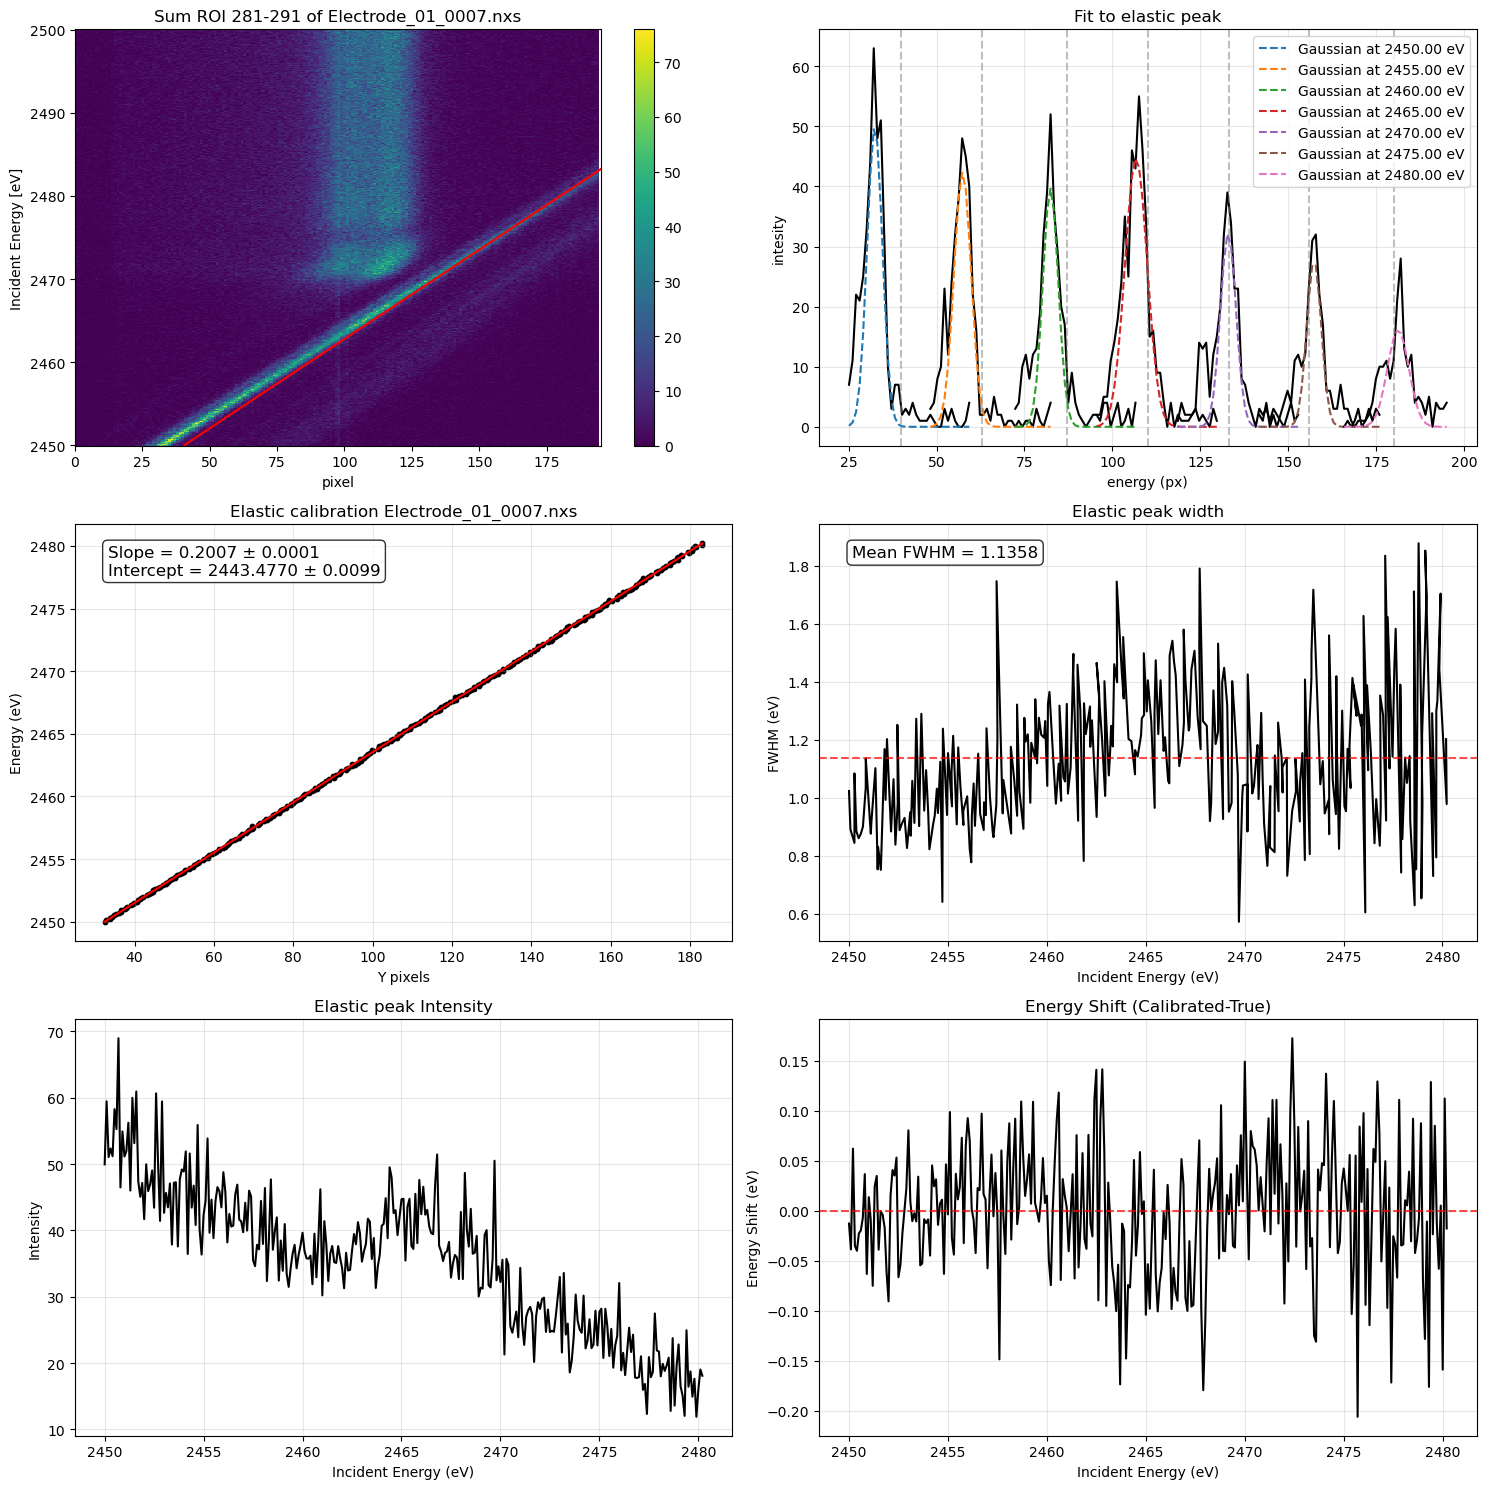

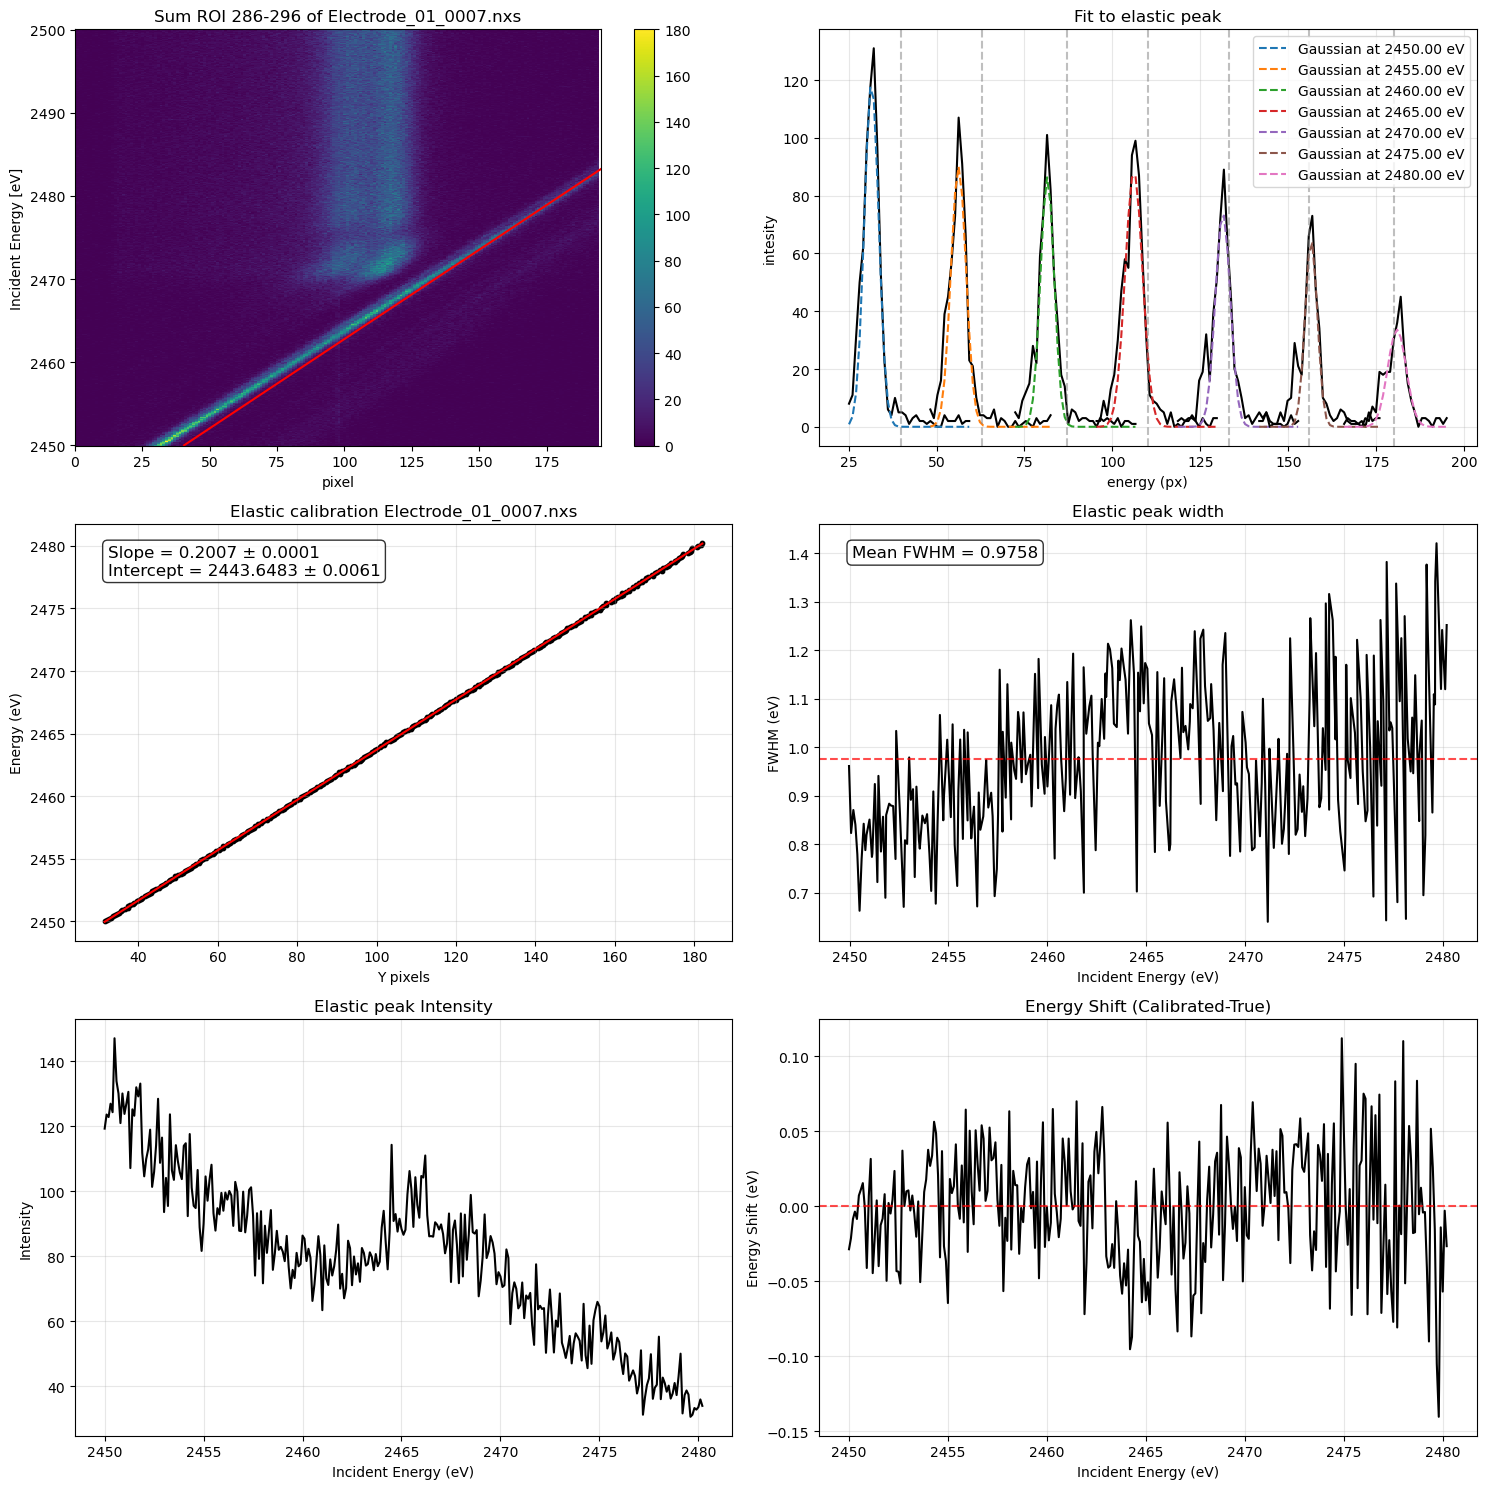

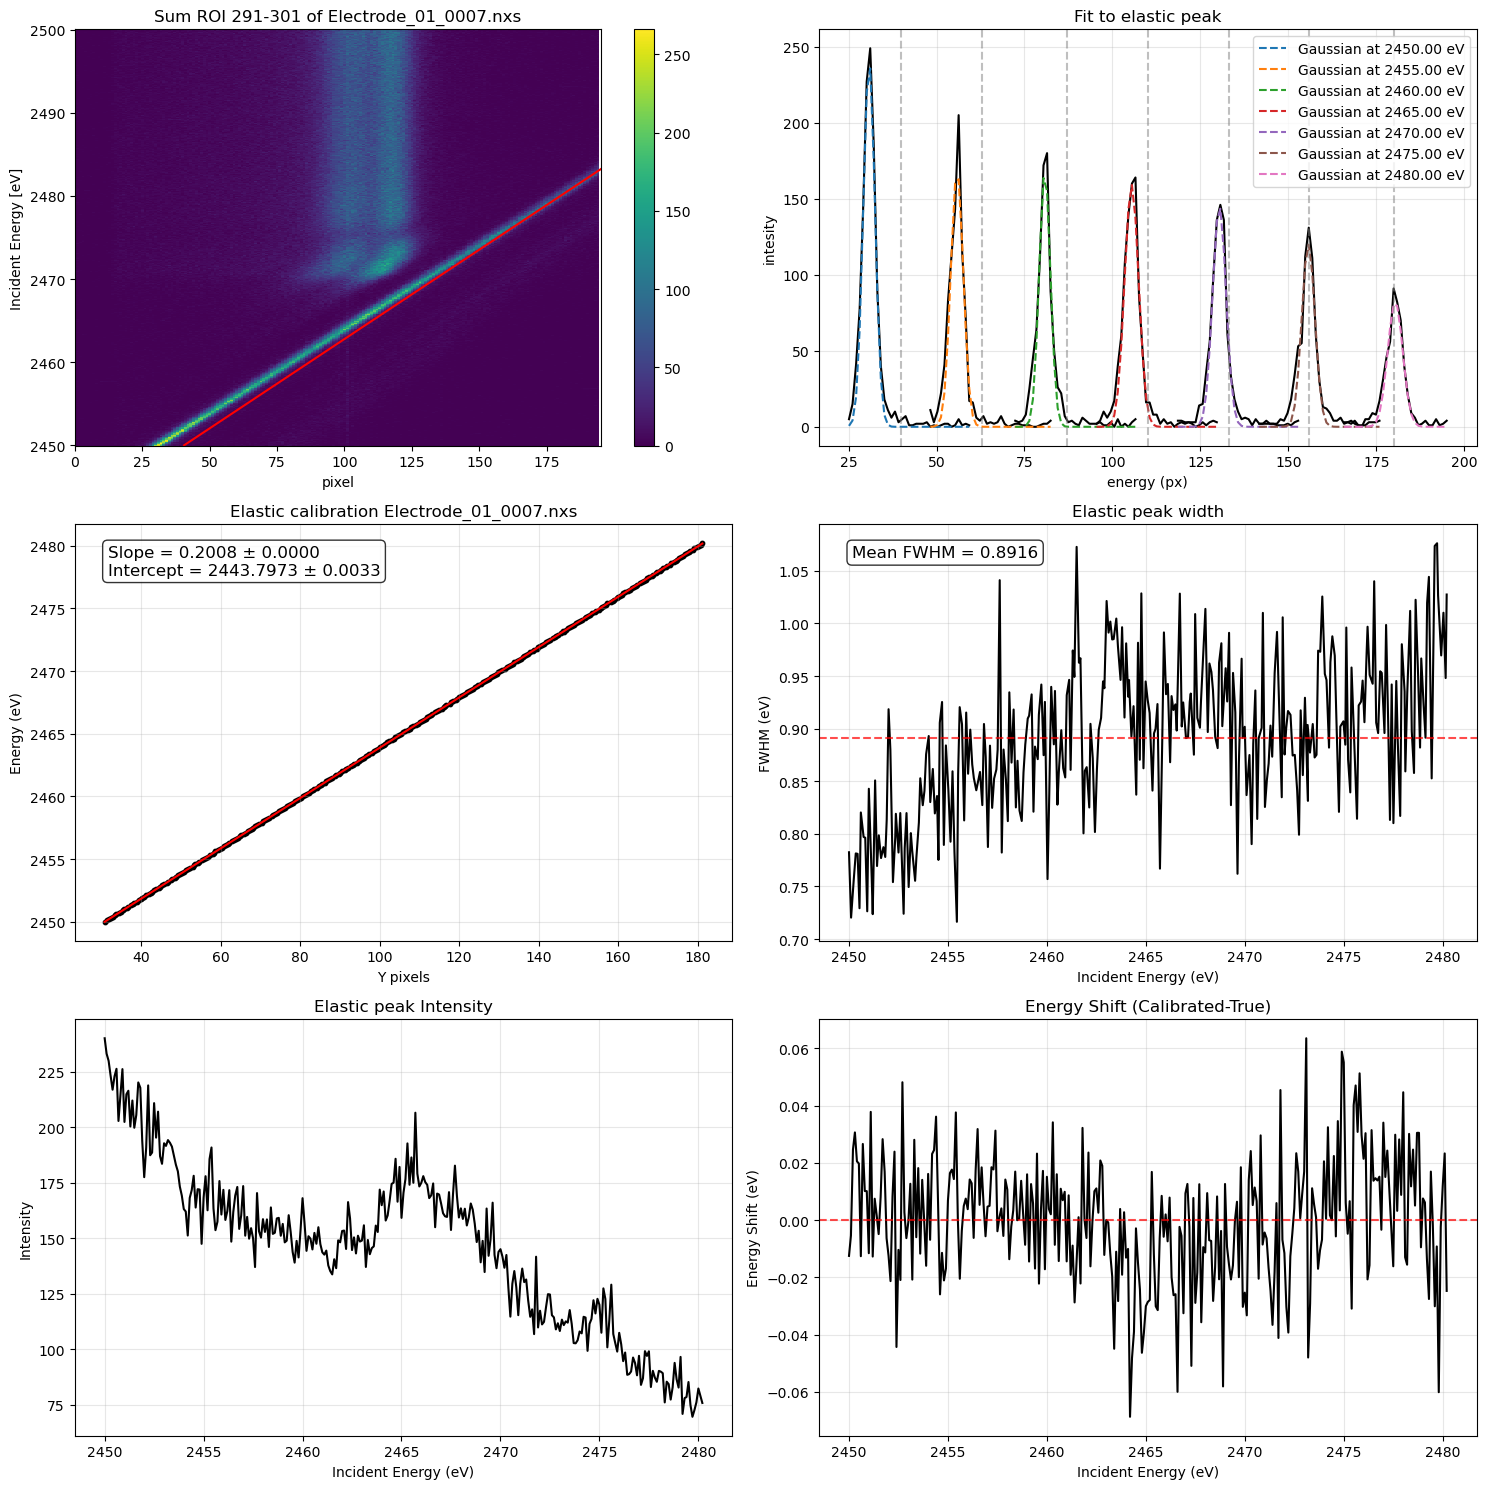

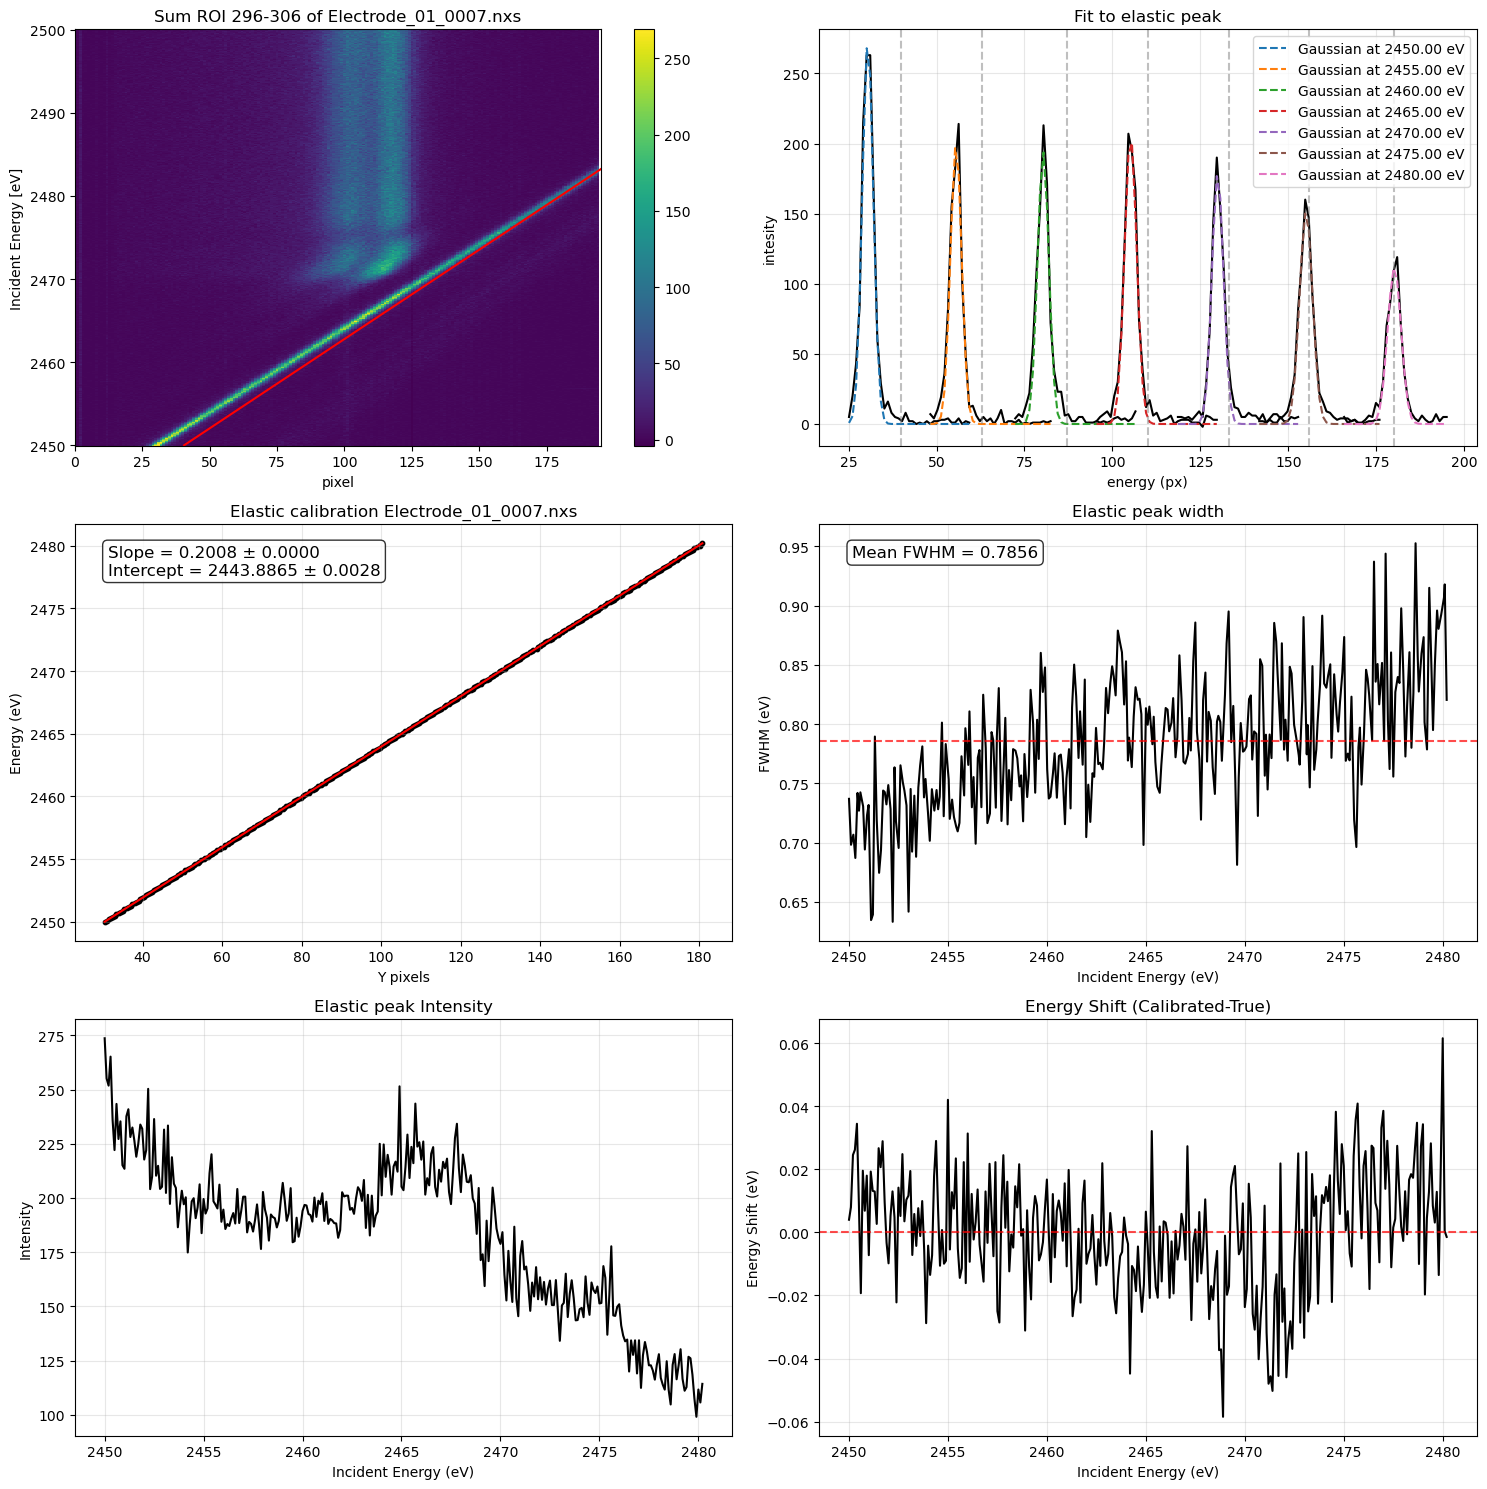

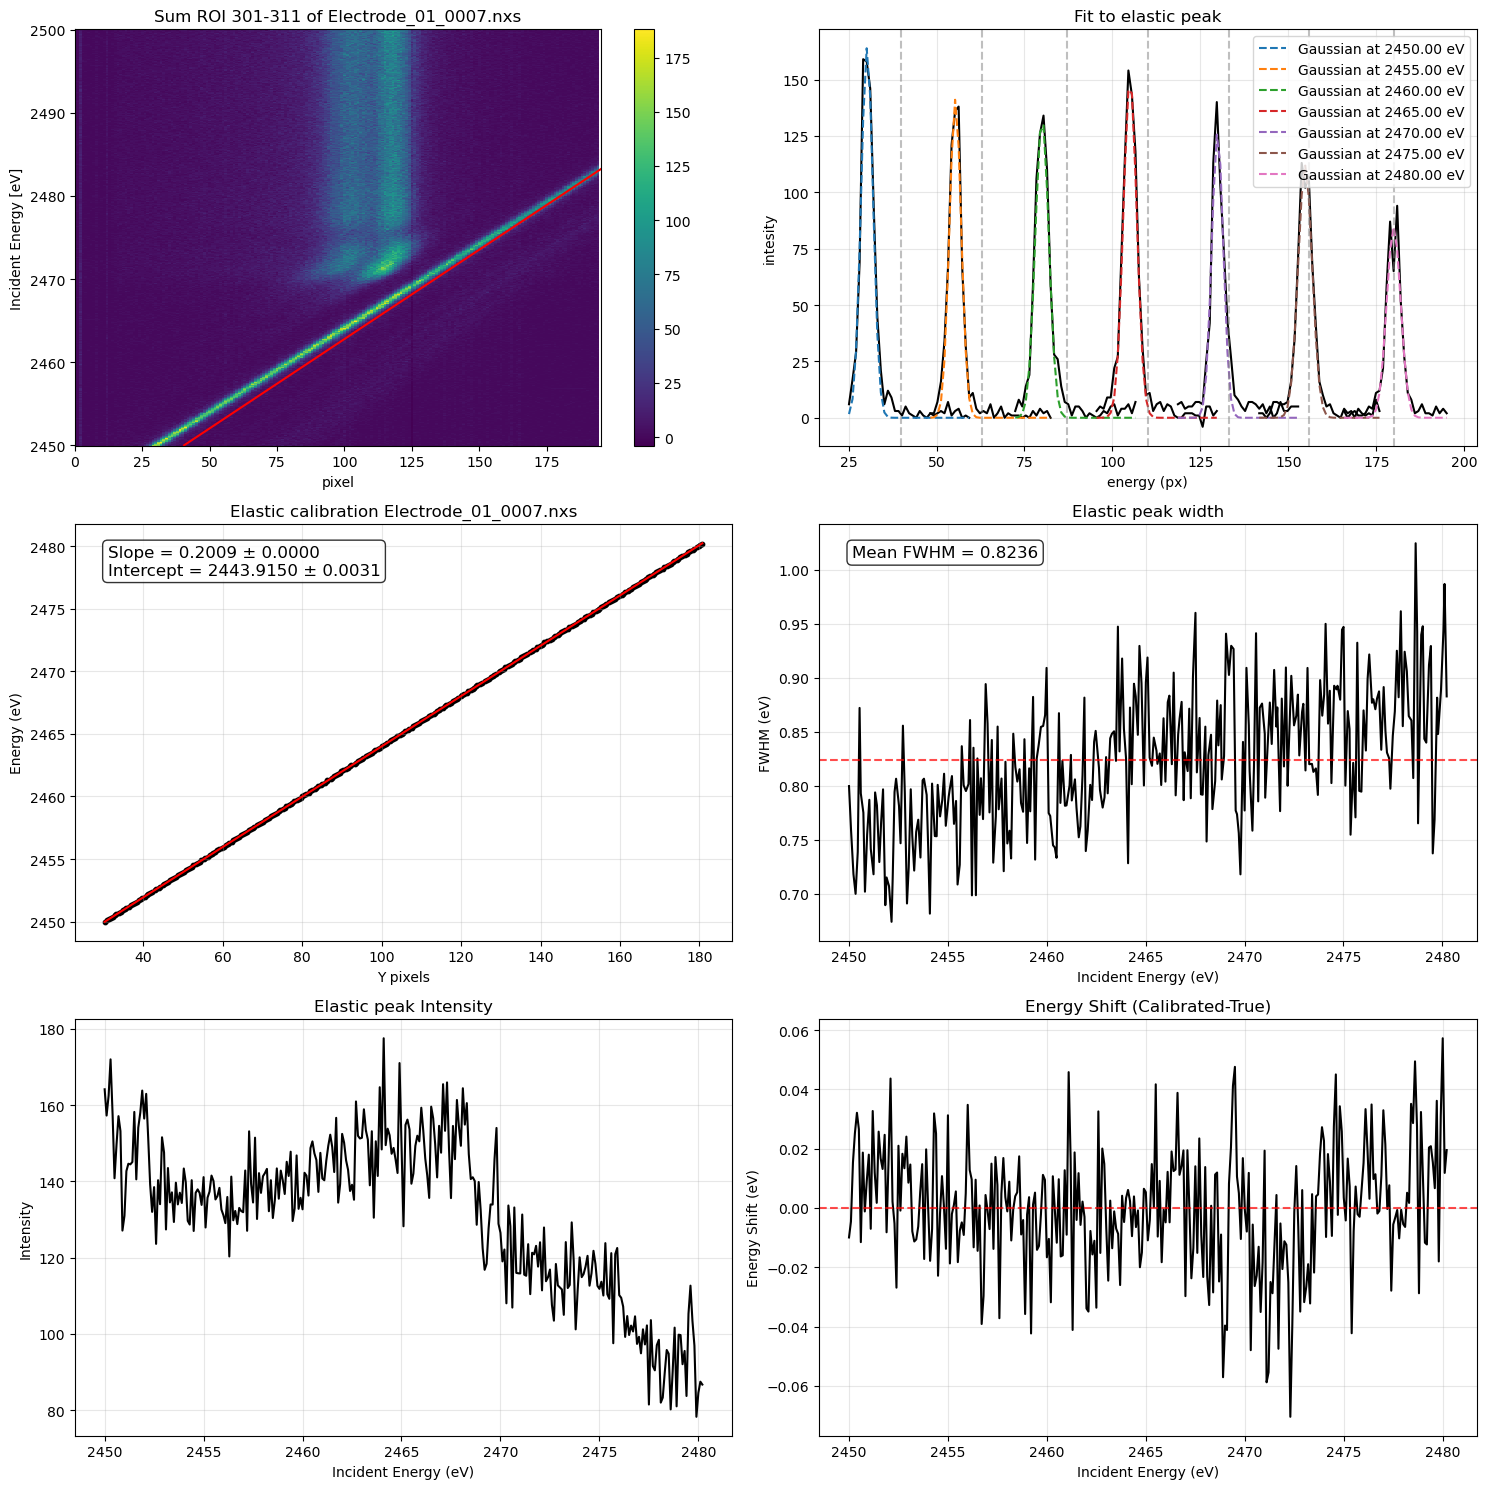

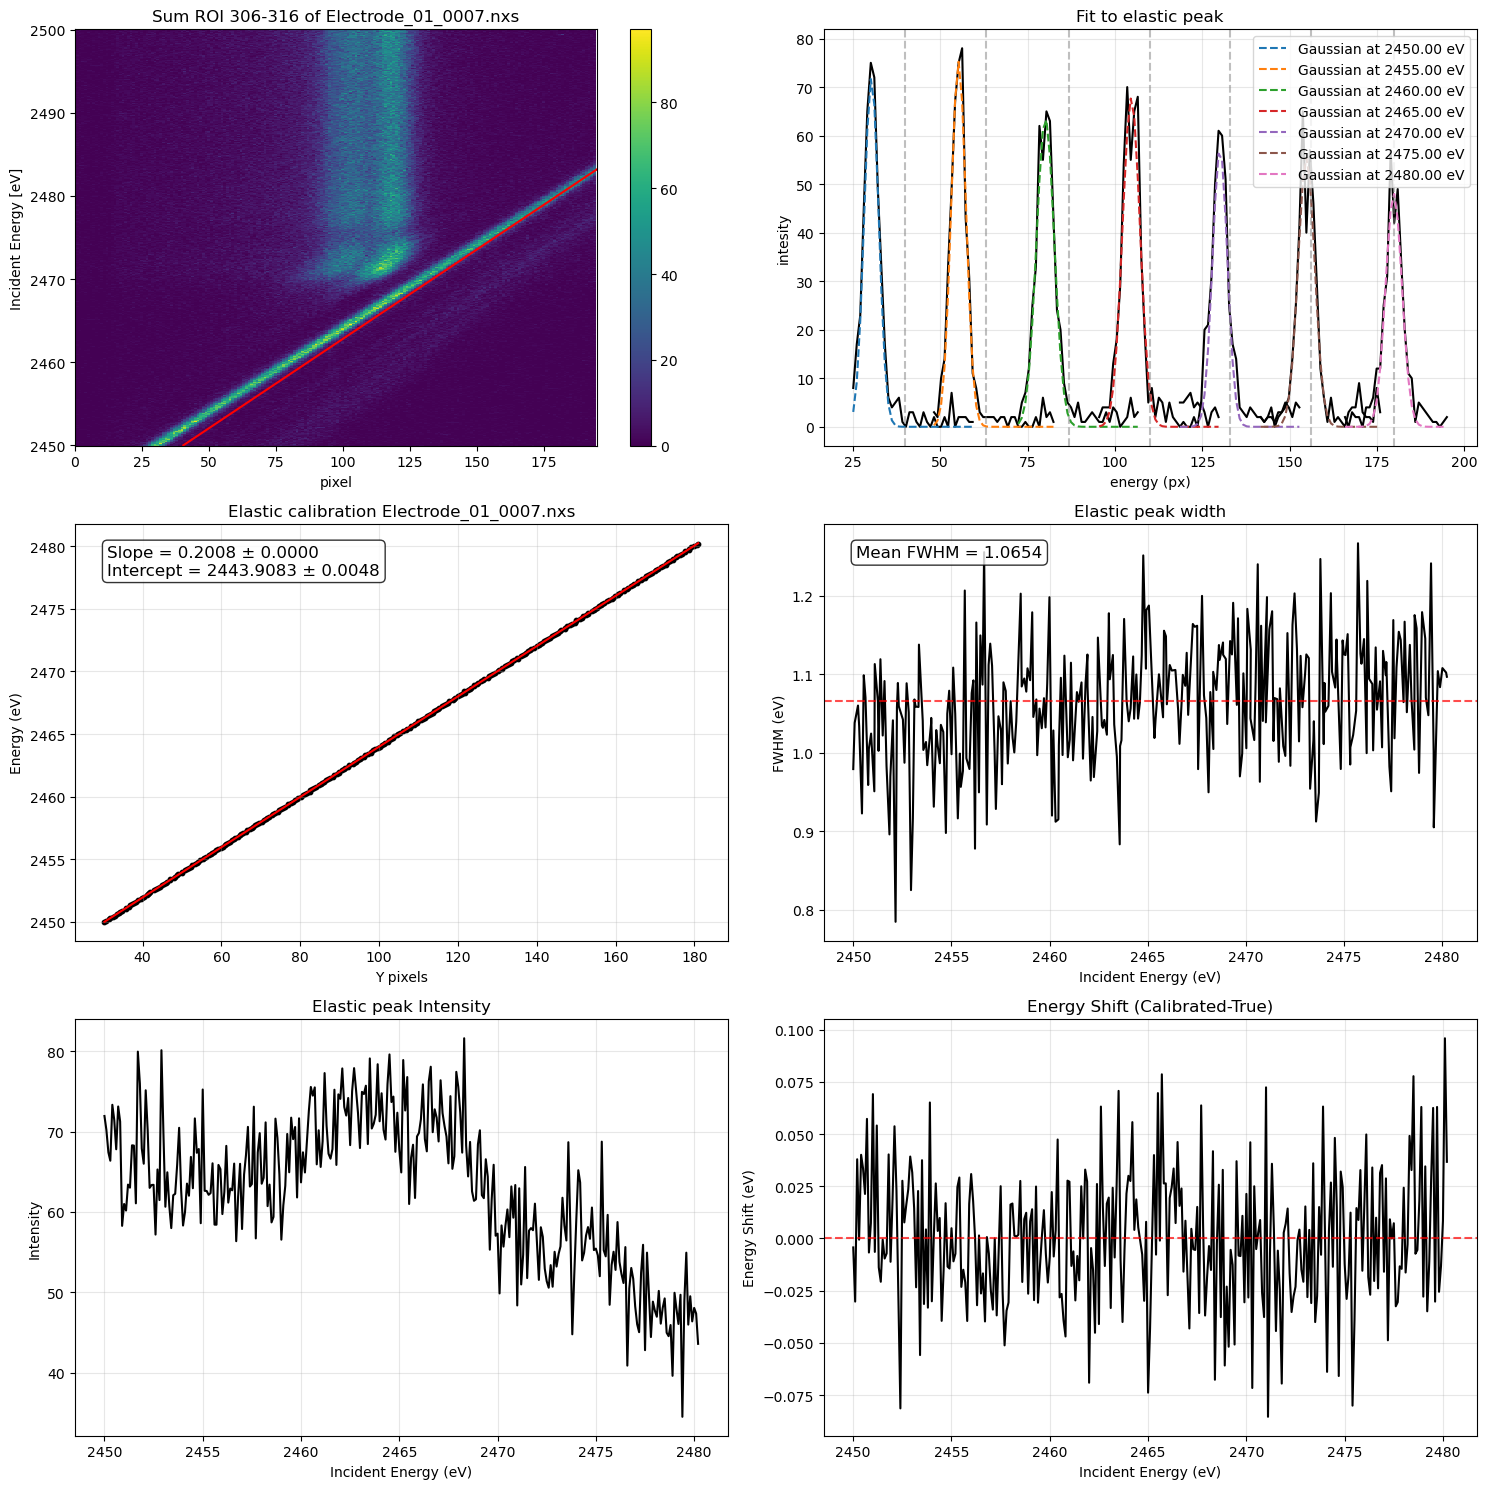

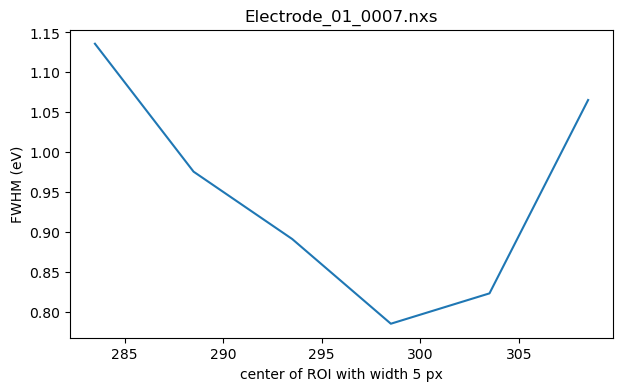

In [107]:
def foo():
    def input_data(offset=0, width=5):
        return {
        'filename': 'Electrode_01_0007.nxs',
        'roi': [280 + offset, 280 + offset + width],
        'vmax': None,
        'line_ends': ((2460, 2480), (87, 180))
        }

    offsets = []
    fwhms = []
    # go from 305 -- 370
    for offset in range(1, 30, 5):
        idata = input_data(offset=offset, width=10)
        df = calibrate_line(**idata, plot=True)
        fwhms.append(df['e_fwhm'].mean())
        offsets.append(offset)

    results_df = pd.DataFrame({"offsets": offsets, "e_fwhm": fwhms})

    fig, ax = plt.subplots(1, 1, figsize=(7, 4))

    ax.plot(results_df["offsets"]+280+2.5, results_df["e_fwhm"])
    ax.set_xlabel(f"center of ROI with width 5 px")
    ax.set_ylabel("FWHM (eV)")
    ax.set_title(f"{input_data()['filename']}")


    return results_df

foo()